# Functional Encryption - Classification and information leakage


# 5. Joint optimisation (Extended results)


We will use the code directly from the repo, to make the notebook more readable. Functions are similar to those presented earlier.

In [1]:
# Allow to load packages from parent
import sys, os
sys.path.insert(1, os.path.realpath(os.path.pardir))

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import learn
from learn import show_results
# We now import from the collateral module
from learn import collateral

Let's define the model with the describes architecture. Basically you have 3 blocs: 1 quadratic and 2 CNN.

In [3]:
PRIVATE_OUTPUT_SIZE = 4
N_CHARS = 10
N_FONTS = 2

class Parser:
    """Parameters for the training"""
    def __init__(self):
        self.epochs = 10
        self.sabotage_epochs = 10
        self.recovering_epochs = 10
        self.lr = 0.002
        self.momentum = 0.5
        self.test_batch_size = 1000
        self.batch_size = 64
        self.log_interval = 300

class CollateralNet(nn.Module):
    def __init__(self):
        super(CollateralNet, self).__init__()
        self.proj1 = nn.Linear(784, 40)
        self.diag1 = nn.Linear(40, PRIVATE_OUTPUT_SIZE, bias=False)

        # --- FFN for characters
        self.lin1 = nn.Linear(PRIVATE_OUTPUT_SIZE, 32)
        self.lin2 = nn.Linear(32, N_CHARS)

        # --- FFN for families
        self.lin3 = nn.Linear(PRIVATE_OUTPUT_SIZE, 32)
        self.lin4 = nn.Linear(32, N_FONTS)

    def quad(self, x):
        # --- Quadratic
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x

    def char_net(self, x):
        # --- FFN
        x = F.relu(x)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x

    def font_net(self, x):
        # --- FFN
        x = F.relu(x)
        x = F.relu(self.lin3(x))
        x = self.lin4(x)
        return x

    def forward_char(self, x):
        x = self.quad(x)
        x = self.char_net(x)
        return F.log_softmax(x, dim=1)

    def forward_font(self, x):
        x = self.quad(x)
        x = self.font_net(x)
        return F.log_softmax(x, dim=1)
    
    # We add the ability to freeze some layers to ensure that the collateral task does
    # not modify the quadratic net
    
    def get_params(self, net):
        """Select the params for a given part of the net"""
        if net == 'quad':
            layers = [self.proj1, self.diag1]
        elif net == 'char':
            layers = [self.lin1, self.lin2]
        elif net == 'font':
            layers = [self.lin3, self.lin4]
        else:
            raise AttributeError(f'{net} type not recognized')
        params = [p for layer in layers for p in layer.parameters()]
        return params

    def freeze(self, net):
        """Freeze a part of the net"""
        net_params = self.get_params(net)
        for param in net_params:
            param.requires_grad = False

    def unfreeze(self):
        """Unfreeze the net"""
        for param in self.parameters():
            param.requires_grad = True
    
    

## 5.1 Introducing sabotage

This function orchestrate the sabotage in three phases like explained in introduction. Note that we change the optimiser because Adam causes some diverging results for alpha > 0.5, so we use the classic SGD instead which also performs very well. (_Note: the learning rate could explain this_)

In [4]:
def build_resistance(model, alpha=0, cv=0):
    """
    Perform a dual learning phase with sabotage
    """
    args = Parser()
    
    train_loader, test_loader = collateral.get_data_loaders(args, cv=cv)

    # optimizer = optim.Adam(model.parameters(), lr=args.lr)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    
    test_perfs_char = []
    test_perfs_font = []
    
    for epoch in range(1, args.epochs + args.sabotage_epochs + args.recovering_epochs + 1):
        initial_phase = epoch <= args.epochs
        if initial_phase:
            print("(initial phase)")
        perturbate = epoch > args.epochs and epoch <= args.epochs + args.sabotage_epochs
        if perturbate:
            print("(perturbate)")
        recover = epoch > args.epochs + args.sabotage_epochs
        if recover:
            print("(recover)")
        collateral.train(
            args, model, train_loader, optimizer, epoch, alpha, 
            initial_phase, perturbate, recover, False
        )
        test_perf_char, test_perf_font = collateral.test(args, model, test_loader, False)
        test_perfs_char.append(test_perf_char)
        test_perfs_font.append(test_perf_font)

    return test_perfs_char, test_perfs_font

In [5]:
results = {}

We use cross validation to strengthen the quality of our results.

In [6]:
alphas = [0, 0.2, 0.5, 1, 1.5, 2, 2.5, 3]  # feel free to drop some values to get afster computation
for cv in range(7):
    for alpha in alphas:
        print('\n -----', alpha, cv)
        model = CollateralNet()
        test_perfs_char_perturbate, test_perfs_font_perturbate = build_resistance(model, alpha, cv)
        results[f"Main task with alpha {cv} {alpha}"] = test_perfs_char_perturbate
        results[f"Collateral task with alpha {cv} {alpha}"] = test_perfs_font_perturbate


 ----- 0
Training set 60000 items
Testing set  10000 items
(initial phase)
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 2.312654 Loss Font: 0.684441
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 1.685660 Loss Font: 0.699166
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 0.614588 Loss Font: 0.675524
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.487851 Loss Font: 0.641966

Test set: Accuracy Char : 8827/10000 (88.27%)
          Accuracy Font : 6116/10000 (61.16%)
(initial phase)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.326948 Loss Font: 0.629483
Train Epoch: 2 [19200/60000 (32%)]	Loss Char: 0.367341 Loss Font: 0.586186
Train Epoch: 2 [38400/60000 (64%)]	Loss Char: 0.161969 Loss Font: 0.556531
Train Epoch: 2 [57600/60000 (96%)]	Loss Char: 0.190801 Loss Font: 0.608041

Test set: Accuracy Char : 9458/10000 (94.58%)
          Accuracy Font : 6735/10000 (67.35%)
(initial phase)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.232397 Loss Font: 0.532022
Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 

Train Epoch: 21 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.462538
Train Epoch: 21 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.534405
Train Epoch: 21 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.477055

Test set: Accuracy Char : 9888/10000 (98.88%)
          Accuracy Font : 7861/10000 (78.61%)
(recover)
Train Epoch: 22 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.451428
Train Epoch: 22 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.580811
Train Epoch: 22 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.397694
Train Epoch: 22 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.394752

Test set: Accuracy Char : 9889/10000 (98.89%)
          Accuracy Font : 7784/10000 (77.84%)
(recover)
Train Epoch: 23 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.338192
Train Epoch: 23 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.411256
Train Epoch: 23 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.441015
Train Epoch: 23 [57600/60000 (96%)]	Loss Cha

Train Epoch: 11 [38400/60000 (64%)]	Loss Char: 0.009952 Loss Font: 0.666486
Train Epoch: 11 [57600/60000 (96%)]	Loss Char: 0.002831 Loss Font: 0.634571

Test set: Accuracy Char : 9818/10000 (98.18%)
          Accuracy Font : 5704/10000 (57.04%)
(perturbate)
Train Epoch: 12 [0/60000 (0%)]	Loss Char: 0.015574 Loss Font: 0.655631
Train Epoch: 12 [19200/60000 (32%)]	Loss Char: 0.025969 Loss Font: 0.614526
Train Epoch: 12 [38400/60000 (64%)]	Loss Char: 0.007707 Loss Font: 0.619948
Train Epoch: 12 [57600/60000 (96%)]	Loss Char: 0.002652 Loss Font: 0.639494

Test set: Accuracy Char : 9818/10000 (98.18%)
          Accuracy Font : 5486/10000 (54.86%)
(perturbate)
Train Epoch: 13 [0/60000 (0%)]	Loss Char: 0.025988 Loss Font: 0.619439
Train Epoch: 13 [19200/60000 (32%)]	Loss Char: 0.006079 Loss Font: 0.603967
Train Epoch: 13 [38400/60000 (64%)]	Loss Char: 0.044970 Loss Font: 0.630859
Train Epoch: 13 [57600/60000 (96%)]	Loss Char: 0.021622 Loss Font: 0.691622

Test set: Accuracy Char : 9824/10000 

Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.353118 Loss Font: 0.824193

Test set: Accuracy Char : 8757/10000 (87.57%)
          Accuracy Font : 5276/10000 (52.76%)
(initial phase)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.395035 Loss Font: 1.221307
Train Epoch: 2 [19200/60000 (32%)]	Loss Char: 0.372798 Loss Font: 0.701106
Train Epoch: 2 [38400/60000 (64%)]	Loss Char: 0.171406 Loss Font: 0.651701
Train Epoch: 2 [57600/60000 (96%)]	Loss Char: 0.129110 Loss Font: 0.720872

Test set: Accuracy Char : 9379/10000 (93.79%)
          Accuracy Font : 5366/10000 (53.66%)
(initial phase)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.152392 Loss Font: 0.792021
Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 0.090562 Loss Font: 0.644152
Train Epoch: 3 [38400/60000 (64%)]	Loss Char: 0.148285 Loss Font: 0.591640
Train Epoch: 3 [57600/60000 (96%)]	Loss Char: 0.188795 Loss Font: 0.563984

Test set: Accuracy Char : 9606/10000 (96.06%)
          Accuracy Font : 6376/10000 (63.76%)
(initial phase)
Train Ep

Train Epoch: 22 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.692290
Train Epoch: 22 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.669103
Train Epoch: 22 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.698659

Test set: Accuracy Char : 9834/10000 (98.34%)
          Accuracy Font : 5482/10000 (54.82%)
(recover)
Train Epoch: 23 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.675471
Train Epoch: 23 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.673316
Train Epoch: 23 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.727936
Train Epoch: 23 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.689658

Test set: Accuracy Char : 9826/10000 (98.26%)
          Accuracy Font : 5367/10000 (53.67%)
(recover)
Train Epoch: 24 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.676379
Train Epoch: 24 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.654941
Train Epoch: 24 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.692600
Train Epoch: 24 [57600/60000 (96%)]	Loss Cha

Train Epoch: 12 [38400/60000 (64%)]	Loss Char: 0.010830 Loss Font: 0.646652
Train Epoch: 12 [57600/60000 (96%)]	Loss Char: 0.001249 Loss Font: 0.670255

Test set: Accuracy Char : 9779/10000 (97.79%)
          Accuracy Font : 5139/10000 (51.39%)
(perturbate)
Train Epoch: 13 [0/60000 (0%)]	Loss Char: 0.080934 Loss Font: 0.658779
Train Epoch: 13 [19200/60000 (32%)]	Loss Char: 0.009014 Loss Font: 0.680143
Train Epoch: 13 [38400/60000 (64%)]	Loss Char: 0.068802 Loss Font: 0.671580
Train Epoch: 13 [57600/60000 (96%)]	Loss Char: 0.016601 Loss Font: 0.689425

Test set: Accuracy Char : 9811/10000 (98.11%)
          Accuracy Font : 4981/10000 (49.81%)
(perturbate)
Train Epoch: 14 [0/60000 (0%)]	Loss Char: 0.005104 Loss Font: 0.661316
Train Epoch: 14 [19200/60000 (32%)]	Loss Char: 0.010878 Loss Font: 0.696391
Train Epoch: 14 [38400/60000 (64%)]	Loss Char: 0.005302 Loss Font: 0.675434
Train Epoch: 14 [57600/60000 (96%)]	Loss Char: 0.002440 Loss Font: 0.709000

Test set: Accuracy Char : 9821/10000 

Train Epoch: 2 [57600/60000 (96%)]	Loss Char: 0.129110 Loss Font: 0.720872

Test set: Accuracy Char : 9379/10000 (93.79%)
          Accuracy Font : 5366/10000 (53.66%)
(initial phase)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.152392 Loss Font: 0.792021
Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 0.090562 Loss Font: 0.644152
Train Epoch: 3 [38400/60000 (64%)]	Loss Char: 0.148285 Loss Font: 0.591640
Train Epoch: 3 [57600/60000 (96%)]	Loss Char: 0.188795 Loss Font: 0.563984

Test set: Accuracy Char : 9606/10000 (96.06%)
          Accuracy Font : 6376/10000 (63.76%)
(initial phase)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.233494 Loss Font: 0.679103
Train Epoch: 4 [19200/60000 (32%)]	Loss Char: 0.043985 Loss Font: 0.596014
Train Epoch: 4 [38400/60000 (64%)]	Loss Char: 0.019758 Loss Font: 0.652676
Train Epoch: 4 [57600/60000 (96%)]	Loss Char: 0.048199 Loss Font: 0.664552

Test set: Accuracy Char : 9699/10000 (96.99%)
          Accuracy Font : 6632/10000 (66.32%)
(initial phase)
Train Ep

Train Epoch: 23 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.671618
Train Epoch: 23 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.719734
Train Epoch: 23 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.690015

Test set: Accuracy Char : 9822/10000 (98.22%)
          Accuracy Font : 5228/10000 (52.28%)
(recover)
Train Epoch: 24 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.681451
Train Epoch: 24 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.670936
Train Epoch: 24 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.714463
Train Epoch: 24 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.690158

Test set: Accuracy Char : 9818/10000 (98.18%)
          Accuracy Font : 5314/10000 (53.14%)
(recover)
Train Epoch: 25 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.694543
Train Epoch: 25 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.682583
Train Epoch: 25 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.702202
Train Epoch: 25 [57600/60000 (96%)]	Loss Cha

Train Epoch: 13 [38400/60000 (64%)]	Loss Char: 0.048228 Loss Font: 0.679041
Train Epoch: 13 [57600/60000 (96%)]	Loss Char: 0.032339 Loss Font: 0.690579

Test set: Accuracy Char : 9799/10000 (97.99%)
          Accuracy Font : 5142/10000 (51.42%)
(perturbate)
Train Epoch: 14 [0/60000 (0%)]	Loss Char: 0.011242 Loss Font: 0.672679
Train Epoch: 14 [19200/60000 (32%)]	Loss Char: 0.014669 Loss Font: 0.692139
Train Epoch: 14 [38400/60000 (64%)]	Loss Char: 0.004811 Loss Font: 0.675150
Train Epoch: 14 [57600/60000 (96%)]	Loss Char: 0.001376 Loss Font: 0.710050

Test set: Accuracy Char : 9814/10000 (98.14%)
          Accuracy Font : 5333/10000 (53.33%)
(perturbate)
Train Epoch: 15 [0/60000 (0%)]	Loss Char: 0.009179 Loss Font: 0.695721
Train Epoch: 15 [19200/60000 (32%)]	Loss Char: 0.007992 Loss Font: 0.694652
Train Epoch: 15 [38400/60000 (64%)]	Loss Char: 0.069136 Loss Font: 0.692439
Train Epoch: 15 [57600/60000 (96%)]	Loss Char: 0.020453 Loss Font: 0.698123

Test set: Accuracy Char : 9802/10000 

Train Epoch: 3 [57600/60000 (96%)]	Loss Char: 0.188795 Loss Font: 0.563984

Test set: Accuracy Char : 9606/10000 (96.06%)
          Accuracy Font : 6376/10000 (63.76%)
(initial phase)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.233494 Loss Font: 0.679103
Train Epoch: 4 [19200/60000 (32%)]	Loss Char: 0.043985 Loss Font: 0.596014
Train Epoch: 4 [38400/60000 (64%)]	Loss Char: 0.019758 Loss Font: 0.652676
Train Epoch: 4 [57600/60000 (96%)]	Loss Char: 0.048199 Loss Font: 0.664552

Test set: Accuracy Char : 9699/10000 (96.99%)
          Accuracy Font : 6632/10000 (66.32%)
(initial phase)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.239423 Loss Font: 0.570931
Train Epoch: 5 [19200/60000 (32%)]	Loss Char: 0.093873 Loss Font: 0.568323
Train Epoch: 5 [38400/60000 (64%)]	Loss Char: 0.196927 Loss Font: 0.687699
Train Epoch: 5 [57600/60000 (96%)]	Loss Char: 0.094887 Loss Font: 0.540527

Test set: Accuracy Char : 9765/10000 (97.65%)
          Accuracy Font : 6614/10000 (66.14%)
(initial phase)
Train Ep

Train Epoch: 24 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.666022
Train Epoch: 24 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.698463
Train Epoch: 24 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.695443

Test set: Accuracy Char : 9816/10000 (98.16%)
          Accuracy Font : 5330/10000 (53.30%)
(recover)
Train Epoch: 25 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.689691
Train Epoch: 25 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.668305
Train Epoch: 25 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.694585
Train Epoch: 25 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.683970

Test set: Accuracy Char : 9818/10000 (98.18%)
          Accuracy Font : 5399/10000 (53.99%)
(recover)
Train Epoch: 26 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.654615
Train Epoch: 26 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.671442
Train Epoch: 26 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.699570
Train Epoch: 26 [57600/60000 (96%)]	Loss Cha

Train Epoch: 14 [38400/60000 (64%)]	Loss Char: 0.001810 Loss Font: 0.684449
Train Epoch: 14 [57600/60000 (96%)]	Loss Char: 0.001924 Loss Font: 0.723217

Test set: Accuracy Char : 9792/10000 (97.92%)
          Accuracy Font : 5252/10000 (52.52%)
(perturbate)
Train Epoch: 15 [0/60000 (0%)]	Loss Char: 0.014748 Loss Font: 0.692303
Train Epoch: 15 [19200/60000 (32%)]	Loss Char: 0.024910 Loss Font: 0.689795
Train Epoch: 15 [38400/60000 (64%)]	Loss Char: 0.040556 Loss Font: 0.690705
Train Epoch: 15 [57600/60000 (96%)]	Loss Char: 0.017527 Loss Font: 0.693765

Test set: Accuracy Char : 9775/10000 (97.75%)
          Accuracy Font : 5114/10000 (51.14%)
(perturbate)
Train Epoch: 16 [0/60000 (0%)]	Loss Char: 0.009902 Loss Font: 0.680169
Train Epoch: 16 [19200/60000 (32%)]	Loss Char: 0.014074 Loss Font: 0.691857
Train Epoch: 16 [38400/60000 (64%)]	Loss Char: 0.021856 Loss Font: 0.691848
Train Epoch: 16 [57600/60000 (96%)]	Loss Char: 0.028938 Loss Font: 0.693293

Test set: Accuracy Char : 9804/10000 

Train Epoch: 4 [57600/60000 (96%)]	Loss Char: 0.029791 Loss Font: 0.656823

Test set: Accuracy Char : 9714/10000 (97.14%)
          Accuracy Font : 6649/10000 (66.49%)
(initial phase)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.195375 Loss Font: 0.573285
Train Epoch: 5 [19200/60000 (32%)]	Loss Char: 0.044881 Loss Font: 0.630764
Train Epoch: 5 [38400/60000 (64%)]	Loss Char: 0.099862 Loss Font: 0.711943
Train Epoch: 5 [57600/60000 (96%)]	Loss Char: 0.098713 Loss Font: 0.560263

Test set: Accuracy Char : 9758/10000 (97.58%)
          Accuracy Font : 6773/10000 (67.73%)
(initial phase)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.107255 Loss Font: 0.585144
Train Epoch: 6 [19200/60000 (32%)]	Loss Char: 0.049504 Loss Font: 0.613187
Train Epoch: 6 [38400/60000 (64%)]	Loss Char: 0.024633 Loss Font: 0.461518
Train Epoch: 6 [57600/60000 (96%)]	Loss Char: 0.009794 Loss Font: 0.585519

Test set: Accuracy Char : 9703/10000 (97.03%)
          Accuracy Font : 6463/10000 (64.63%)
(initial phase)
Train Ep

Train Epoch: 25 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.434740
Train Epoch: 25 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.466331
Train Epoch: 25 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.503423

Test set: Accuracy Char : 9878/10000 (98.78%)
          Accuracy Font : 7472/10000 (74.72%)
(recover)
Train Epoch: 26 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.319425
Train Epoch: 26 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.447335
Train Epoch: 26 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.495027
Train Epoch: 26 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.547263

Test set: Accuracy Char : 9877/10000 (98.77%)
          Accuracy Font : 7520/10000 (75.20%)
(recover)
Train Epoch: 27 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.463019
Train Epoch: 27 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.494235
Train Epoch: 27 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.632129
Train Epoch: 27 [57600/60000 (96%)]	Loss Cha

Train Epoch: 15 [38400/60000 (64%)]	Loss Char: 0.014578 Loss Font: 0.622702
Train Epoch: 15 [57600/60000 (96%)]	Loss Char: 0.003347 Loss Font: 0.648018

Test set: Accuracy Char : 9848/10000 (98.48%)
          Accuracy Font : 5811/10000 (58.11%)
(perturbate)
Train Epoch: 16 [0/60000 (0%)]	Loss Char: 0.003733 Loss Font: 0.617887
Train Epoch: 16 [19200/60000 (32%)]	Loss Char: 0.023527 Loss Font: 0.615828
Train Epoch: 16 [38400/60000 (64%)]	Loss Char: 0.028722 Loss Font: 0.664053
Train Epoch: 16 [57600/60000 (96%)]	Loss Char: 0.054089 Loss Font: 0.622386

Test set: Accuracy Char : 9855/10000 (98.55%)
          Accuracy Font : 5842/10000 (58.42%)
(perturbate)
Train Epoch: 17 [0/60000 (0%)]	Loss Char: 0.008710 Loss Font: 0.642816
Train Epoch: 17 [19200/60000 (32%)]	Loss Char: 0.016178 Loss Font: 0.651360
Train Epoch: 17 [38400/60000 (64%)]	Loss Char: 0.073688 Loss Font: 0.654167
Train Epoch: 17 [57600/60000 (96%)]	Loss Char: 0.005319 Loss Font: 0.630209

Test set: Accuracy Char : 9851/10000 

Train Epoch: 5 [57600/60000 (96%)]	Loss Char: 0.098713 Loss Font: 0.560263

Test set: Accuracy Char : 9758/10000 (97.58%)
          Accuracy Font : 6773/10000 (67.73%)
(initial phase)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.107255 Loss Font: 0.585144
Train Epoch: 6 [19200/60000 (32%)]	Loss Char: 0.049504 Loss Font: 0.613187
Train Epoch: 6 [38400/60000 (64%)]	Loss Char: 0.024633 Loss Font: 0.461518
Train Epoch: 6 [57600/60000 (96%)]	Loss Char: 0.009794 Loss Font: 0.585519

Test set: Accuracy Char : 9703/10000 (97.03%)
          Accuracy Font : 6463/10000 (64.63%)
(initial phase)
Train Epoch: 7 [0/60000 (0%)]	Loss Char: 0.087062 Loss Font: 0.656786
Train Epoch: 7 [19200/60000 (32%)]	Loss Char: 0.011286 Loss Font: 0.540283
Train Epoch: 7 [38400/60000 (64%)]	Loss Char: 0.028813 Loss Font: 0.627588
Train Epoch: 7 [57600/60000 (96%)]	Loss Char: 0.021150 Loss Font: 0.596656

Test set: Accuracy Char : 9700/10000 (97.00%)
          Accuracy Font : 6784/10000 (67.84%)
(initial phase)
Train Ep

Train Epoch: 26 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.651860
Train Epoch: 26 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.698004
Train Epoch: 26 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.693900

Test set: Accuracy Char : 9851/10000 (98.51%)
          Accuracy Font : 5730/10000 (57.30%)
(recover)
Train Epoch: 27 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.675815
Train Epoch: 27 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.706108
Train Epoch: 27 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.698758
Train Epoch: 27 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.665491

Test set: Accuracy Char : 9850/10000 (98.50%)
          Accuracy Font : 5660/10000 (56.60%)
(recover)
Train Epoch: 28 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.655740
Train Epoch: 28 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.677737
Train Epoch: 28 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.649148
Train Epoch: 28 [57600/60000 (96%)]	Loss Cha

Train Epoch: 16 [38400/60000 (64%)]	Loss Char: 0.021175 Loss Font: 0.680833
Train Epoch: 16 [57600/60000 (96%)]	Loss Char: 0.092827 Loss Font: 0.678011

Test set: Accuracy Char : 9840/10000 (98.40%)
          Accuracy Font : 5112/10000 (51.12%)
(perturbate)
Train Epoch: 17 [0/60000 (0%)]	Loss Char: 0.008026 Loss Font: 0.693480
Train Epoch: 17 [19200/60000 (32%)]	Loss Char: 0.010776 Loss Font: 0.662041
Train Epoch: 17 [38400/60000 (64%)]	Loss Char: 0.105222 Loss Font: 0.688300
Train Epoch: 17 [57600/60000 (96%)]	Loss Char: 0.014843 Loss Font: 0.675477

Test set: Accuracy Char : 9826/10000 (98.26%)
          Accuracy Font : 5028/10000 (50.28%)
(perturbate)
Train Epoch: 18 [0/60000 (0%)]	Loss Char: 0.010582 Loss Font: 0.695726
Train Epoch: 18 [19200/60000 (32%)]	Loss Char: 0.017875 Loss Font: 0.699318
Train Epoch: 18 [38400/60000 (64%)]	Loss Char: 0.006390 Loss Font: 0.660220
Train Epoch: 18 [57600/60000 (96%)]	Loss Char: 0.011634 Loss Font: 0.693414

Test set: Accuracy Char : 9851/10000 

Train Epoch: 6 [57600/60000 (96%)]	Loss Char: 0.009794 Loss Font: 0.585519

Test set: Accuracy Char : 9703/10000 (97.03%)
          Accuracy Font : 6463/10000 (64.63%)
(initial phase)
Train Epoch: 7 [0/60000 (0%)]	Loss Char: 0.087062 Loss Font: 0.656786
Train Epoch: 7 [19200/60000 (32%)]	Loss Char: 0.011286 Loss Font: 0.540283
Train Epoch: 7 [38400/60000 (64%)]	Loss Char: 0.028813 Loss Font: 0.627588
Train Epoch: 7 [57600/60000 (96%)]	Loss Char: 0.021150 Loss Font: 0.596656

Test set: Accuracy Char : 9700/10000 (97.00%)
          Accuracy Font : 6784/10000 (67.84%)
(initial phase)
Train Epoch: 8 [0/60000 (0%)]	Loss Char: 0.032915 Loss Font: 0.569360
Train Epoch: 8 [19200/60000 (32%)]	Loss Char: 0.039438 Loss Font: 0.641963
Train Epoch: 8 [38400/60000 (64%)]	Loss Char: 0.070115 Loss Font: 0.525936
Train Epoch: 8 [57600/60000 (96%)]	Loss Char: 0.121455 Loss Font: 0.540399

Test set: Accuracy Char : 9796/10000 (97.96%)
          Accuracy Font : 7167/10000 (71.67%)
(initial phase)
Train Ep

Train Epoch: 27 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.677482
Train Epoch: 27 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.702422
Train Epoch: 27 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.703665

Test set: Accuracy Char : 9842/10000 (98.42%)
          Accuracy Font : 5828/10000 (58.28%)
(recover)
Train Epoch: 28 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.642426
Train Epoch: 28 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.673624
Train Epoch: 28 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.668370
Train Epoch: 28 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.669469

Test set: Accuracy Char : 9848/10000 (98.48%)
          Accuracy Font : 5734/10000 (57.34%)
(recover)
Train Epoch: 29 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.702846
Train Epoch: 29 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.664565
Train Epoch: 29 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.683806
Train Epoch: 29 [57600/60000 (96%)]	Loss Cha

Train Epoch: 17 [38400/60000 (64%)]	Loss Char: 0.134781 Loss Font: 0.686228
Train Epoch: 17 [57600/60000 (96%)]	Loss Char: 0.023907 Loss Font: 0.672272

Test set: Accuracy Char : 9816/10000 (98.16%)
          Accuracy Font : 4996/10000 (49.96%)
(perturbate)
Train Epoch: 18 [0/60000 (0%)]	Loss Char: 0.053699 Loss Font: 0.700141
Train Epoch: 18 [19200/60000 (32%)]	Loss Char: 0.034859 Loss Font: 0.702926
Train Epoch: 18 [38400/60000 (64%)]	Loss Char: 0.005264 Loss Font: 0.659581
Train Epoch: 18 [57600/60000 (96%)]	Loss Char: 0.011153 Loss Font: 0.686072

Test set: Accuracy Char : 9826/10000 (98.26%)
          Accuracy Font : 5012/10000 (50.12%)
(perturbate)
Train Epoch: 19 [0/60000 (0%)]	Loss Char: 0.024145 Loss Font: 0.710779
Train Epoch: 19 [19200/60000 (32%)]	Loss Char: 0.074815 Loss Font: 0.695987
Train Epoch: 19 [38400/60000 (64%)]	Loss Char: 0.110913 Loss Font: 0.689883
Train Epoch: 19 [57600/60000 (96%)]	Loss Char: 0.005581 Loss Font: 0.692370

Test set: Accuracy Char : 9822/10000 

Train Epoch: 7 [57600/60000 (96%)]	Loss Char: 0.021150 Loss Font: 0.596656

Test set: Accuracy Char : 9700/10000 (97.00%)
          Accuracy Font : 6784/10000 (67.84%)
(initial phase)
Train Epoch: 8 [0/60000 (0%)]	Loss Char: 0.032915 Loss Font: 0.569360
Train Epoch: 8 [19200/60000 (32%)]	Loss Char: 0.039438 Loss Font: 0.641963
Train Epoch: 8 [38400/60000 (64%)]	Loss Char: 0.070115 Loss Font: 0.525936
Train Epoch: 8 [57600/60000 (96%)]	Loss Char: 0.121455 Loss Font: 0.540399

Test set: Accuracy Char : 9796/10000 (97.96%)
          Accuracy Font : 7167/10000 (71.67%)
(initial phase)
Train Epoch: 9 [0/60000 (0%)]	Loss Char: 0.060533 Loss Font: 0.616677
Train Epoch: 9 [19200/60000 (32%)]	Loss Char: 0.023133 Loss Font: 0.537618
Train Epoch: 9 [38400/60000 (64%)]	Loss Char: 0.035182 Loss Font: 0.545204
Train Epoch: 9 [57600/60000 (96%)]	Loss Char: 0.019553 Loss Font: 0.579361

Test set: Accuracy Char : 9823/10000 (98.23%)
          Accuracy Font : 7108/10000 (71.08%)
(initial phase)
Train Ep

Train Epoch: 28 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.659283
Train Epoch: 28 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.645944
Train Epoch: 28 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.655846

Test set: Accuracy Char : 9832/10000 (98.32%)
          Accuracy Font : 5592/10000 (55.92%)
(recover)
Train Epoch: 29 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.692769
Train Epoch: 29 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.676444
Train Epoch: 29 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.690352
Train Epoch: 29 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.651284

Test set: Accuracy Char : 9833/10000 (98.33%)
          Accuracy Font : 5534/10000 (55.34%)
(recover)
Train Epoch: 30 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.671751
Train Epoch: 30 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.670270
Train Epoch: 30 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.656017
Train Epoch: 30 [57600/60000 (96%)]	Loss Cha

Train Epoch: 18 [38400/60000 (64%)]	Loss Char: 0.010810 Loss Font: 0.669597
Train Epoch: 18 [57600/60000 (96%)]	Loss Char: 0.014059 Loss Font: 0.684264

Test set: Accuracy Char : 9808/10000 (98.08%)
          Accuracy Font : 4995/10000 (49.95%)
(perturbate)
Train Epoch: 19 [0/60000 (0%)]	Loss Char: 0.020119 Loss Font: 0.707599
Train Epoch: 19 [19200/60000 (32%)]	Loss Char: 0.110096 Loss Font: 0.693301
Train Epoch: 19 [38400/60000 (64%)]	Loss Char: 0.104547 Loss Font: 0.689412
Train Epoch: 19 [57600/60000 (96%)]	Loss Char: 0.003367 Loss Font: 0.693194

Test set: Accuracy Char : 9823/10000 (98.23%)
          Accuracy Font : 5068/10000 (50.68%)
(perturbate)
Train Epoch: 20 [0/60000 (0%)]	Loss Char: 0.049831 Loss Font: 0.676067
Train Epoch: 20 [19200/60000 (32%)]	Loss Char: 0.030947 Loss Font: 0.693820
Train Epoch: 20 [38400/60000 (64%)]	Loss Char: 0.034640 Loss Font: 0.707592
Train Epoch: 20 [57600/60000 (96%)]	Loss Char: 0.010497 Loss Font: 0.686588

Test set: Accuracy Char : 9831/10000 

Train Epoch: 8 [57600/60000 (96%)]	Loss Char: 0.100202 Loss Font: 0.554530

Test set: Accuracy Char : 9817/10000 (98.17%)
          Accuracy Font : 7168/10000 (71.68%)
(initial phase)
Train Epoch: 9 [0/60000 (0%)]	Loss Char: 0.014836 Loss Font: 0.595618
Train Epoch: 9 [19200/60000 (32%)]	Loss Char: 0.010142 Loss Font: 0.537060
Train Epoch: 9 [38400/60000 (64%)]	Loss Char: 0.029716 Loss Font: 0.564426
Train Epoch: 9 [57600/60000 (96%)]	Loss Char: 0.018649 Loss Font: 0.578090

Test set: Accuracy Char : 9813/10000 (98.13%)
          Accuracy Font : 7043/10000 (70.43%)
(initial phase)
Train Epoch: 10 [0/60000 (0%)]	Loss Char: 0.011122 Loss Font: 0.571765
Train Epoch: 10 [19200/60000 (32%)]	Loss Char: 0.002885 Loss Font: 0.541547
Train Epoch: 10 [38400/60000 (64%)]	Loss Char: 0.022306 Loss Font: 0.607609
Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.146396 Loss Font: 0.644322

Test set: Accuracy Char : 9850/10000 (98.50%)
          Accuracy Font : 6950/10000 (69.50%)
(perturbate)
Train E

Train Epoch: 29 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.540177
Train Epoch: 29 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.587624
Train Epoch: 29 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.567540

Test set: Accuracy Char : 9891/10000 (98.91%)
          Accuracy Font : 7128/10000 (71.28%)
(recover)
Train Epoch: 30 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.598062
Train Epoch: 30 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.575371
Train Epoch: 30 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.424655
Train Epoch: 30 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.414207

Test set: Accuracy Char : 9888/10000 (98.88%)
          Accuracy Font : 7280/10000 (72.80%)

 ----- 0.2
Training set 60000 items
Testing set  10000 items
(initial phase)
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 2.296798 Loss Font: 0.687512
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 1.623387 Loss Font: 0.677450
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 0.617118

Train Epoch: 19 [38400/60000 (64%)]	Loss Char: 0.109359 Loss Font: 0.662328
Train Epoch: 19 [57600/60000 (96%)]	Loss Char: 0.003307 Loss Font: 0.705374

Test set: Accuracy Char : 9855/10000 (98.55%)
          Accuracy Font : 5524/10000 (55.24%)
(perturbate)
Train Epoch: 20 [0/60000 (0%)]	Loss Char: 0.005927 Loss Font: 0.737120
Train Epoch: 20 [19200/60000 (32%)]	Loss Char: 0.040935 Loss Font: 0.603917
Train Epoch: 20 [38400/60000 (64%)]	Loss Char: 0.005766 Loss Font: 0.660733
Train Epoch: 20 [57600/60000 (96%)]	Loss Char: 0.010973 Loss Font: 0.647243

Test set: Accuracy Char : 9866/10000 (98.66%)
          Accuracy Font : 5660/10000 (56.60%)
(recover)
Train Epoch: 21 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.640754
Train Epoch: 21 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.681524
Train Epoch: 21 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.652942
Train Epoch: 21 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.664856

Test set: Accuracy Char : 9866/10000 (98

Train Epoch: 9 [57600/60000 (96%)]	Loss Char: 0.018649 Loss Font: 0.578090

Test set: Accuracy Char : 9813/10000 (98.13%)
          Accuracy Font : 7043/10000 (70.43%)
(initial phase)
Train Epoch: 10 [0/60000 (0%)]	Loss Char: 0.011122 Loss Font: 0.571765
Train Epoch: 10 [19200/60000 (32%)]	Loss Char: 0.002885 Loss Font: 0.541547
Train Epoch: 10 [38400/60000 (64%)]	Loss Char: 0.022306 Loss Font: 0.607609
Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.146396 Loss Font: 0.644322

Test set: Accuracy Char : 9850/10000 (98.50%)
          Accuracy Font : 6950/10000 (69.50%)
(perturbate)
Train Epoch: 11 [0/60000 (0%)]	Loss Char: 0.005698 Loss Font: 0.464324
Train Epoch: 11 [19200/60000 (32%)]	Loss Char: 0.032325 Loss Font: 0.763592
Train Epoch: 11 [38400/60000 (64%)]	Loss Char: 0.013709 Loss Font: 0.698223
Train Epoch: 11 [57600/60000 (96%)]	Loss Char: 0.004239 Loss Font: 0.688366

Test set: Accuracy Char : 9822/10000 (98.22%)
          Accuracy Font : 5315/10000 (53.15%)
(perturbate)
Train 

Train Epoch: 30 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.706780
Train Epoch: 30 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.687627
Train Epoch: 30 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.658855

Test set: Accuracy Char : 9860/10000 (98.60%)
          Accuracy Font : 5607/10000 (56.07%)

 ----- 1
Training set 60000 items
Testing set  10000 items
(initial phase)
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 2.296798 Loss Font: 0.687512
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 1.623387 Loss Font: 0.677450
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 0.617118 Loss Font: 0.658369
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.352154 Loss Font: 0.641171

Test set: Accuracy Char : 8808/10000 (88.08%)
          Accuracy Font : 5871/10000 (58.71%)
(initial phase)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.392643 Loss Font: 0.808863
Train Epoch: 2 [19200/60000 (32%)]	Loss Char: 0.174345 Loss Font: 0.684996
Train Epoch: 2 [38400/60000 (64%)]	Loss Char: 0.194646

Train Epoch: 20 [38400/60000 (64%)]	Loss Char: 0.018111 Loss Font: 0.685019
Train Epoch: 20 [57600/60000 (96%)]	Loss Char: 0.020647 Loss Font: 0.670546

Test set: Accuracy Char : 9849/10000 (98.49%)
          Accuracy Font : 5120/10000 (51.20%)
(recover)
Train Epoch: 21 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.690207
Train Epoch: 21 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.684355
Train Epoch: 21 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.692932
Train Epoch: 21 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.674004

Test set: Accuracy Char : 9855/10000 (98.55%)
          Accuracy Font : 5014/10000 (50.14%)
(recover)
Train Epoch: 22 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.679308
Train Epoch: 22 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.696103
Train Epoch: 22 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.670638
Train Epoch: 22 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.675310

Test set: Accuracy Char : 9855/10000 (98.55

Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.146396 Loss Font: 0.644322

Test set: Accuracy Char : 9850/10000 (98.50%)
          Accuracy Font : 6950/10000 (69.50%)
(perturbate)
Train Epoch: 11 [0/60000 (0%)]	Loss Char: 0.005698 Loss Font: 0.464324
Train Epoch: 11 [19200/60000 (32%)]	Loss Char: 0.075784 Loss Font: 0.748865
Train Epoch: 11 [38400/60000 (64%)]	Loss Char: 0.095142 Loss Font: 0.736298
Train Epoch: 11 [57600/60000 (96%)]	Loss Char: 0.010007 Loss Font: 0.708478

Test set: Accuracy Char : 9765/10000 (97.65%)
          Accuracy Font : 4989/10000 (49.89%)
(perturbate)
Train Epoch: 12 [0/60000 (0%)]	Loss Char: 0.013698 Loss Font: 0.705054
Train Epoch: 12 [19200/60000 (32%)]	Loss Char: 0.009097 Loss Font: 0.677705
Train Epoch: 12 [38400/60000 (64%)]	Loss Char: 0.119516 Loss Font: 0.691059
Train Epoch: 12 [57600/60000 (96%)]	Loss Char: 0.004550 Loss Font: 0.669175

Test set: Accuracy Char : 9807/10000 (98.07%)
          Accuracy Font : 5017/10000 (50.17%)
(perturbate)
Train Ep

Training set 60000 items
Testing set  10000 items
(initial phase)
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 2.296798 Loss Font: 0.687512
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 1.623387 Loss Font: 0.677450
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 0.617118 Loss Font: 0.658369
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.352154 Loss Font: 0.641171

Test set: Accuracy Char : 8808/10000 (88.08%)
          Accuracy Font : 5871/10000 (58.71%)
(initial phase)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.392643 Loss Font: 0.808863
Train Epoch: 2 [19200/60000 (32%)]	Loss Char: 0.174345 Loss Font: 0.684996
Train Epoch: 2 [38400/60000 (64%)]	Loss Char: 0.194646 Loss Font: 0.599876
Train Epoch: 2 [57600/60000 (96%)]	Loss Char: 0.131077 Loss Font: 0.696916

Test set: Accuracy Char : 9504/10000 (95.04%)
          Accuracy Font : 6317/10000 (63.17%)
(initial phase)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.094827 Loss Font: 0.591764
Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 0.118212 L

Train Epoch: 21 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.685877
Train Epoch: 21 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.684649
Train Epoch: 21 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.677225

Test set: Accuracy Char : 9842/10000 (98.42%)
          Accuracy Font : 5140/10000 (51.40%)
(recover)
Train Epoch: 22 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693260
Train Epoch: 22 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.707609
Train Epoch: 22 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.669663
Train Epoch: 22 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.675139

Test set: Accuracy Char : 9853/10000 (98.53%)
          Accuracy Font : 5166/10000 (51.66%)
(recover)
Train Epoch: 23 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.690666
Train Epoch: 23 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.678294
Train Epoch: 23 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.712582
Train Epoch: 23 [57600/60000 (96%)]	Loss Cha

Train Epoch: 11 [38400/60000 (64%)]	Loss Char: 0.017211 Loss Font: 0.731726
Train Epoch: 11 [57600/60000 (96%)]	Loss Char: 0.014030 Loss Font: 0.728188

Test set: Accuracy Char : 9732/10000 (97.32%)
          Accuracy Font : 5244/10000 (52.44%)
(perturbate)
Train Epoch: 12 [0/60000 (0%)]	Loss Char: 0.038887 Loss Font: 0.711361
Train Epoch: 12 [19200/60000 (32%)]	Loss Char: 0.088123 Loss Font: 0.685073
Train Epoch: 12 [38400/60000 (64%)]	Loss Char: 0.048228 Loss Font: 0.665028
Train Epoch: 12 [57600/60000 (96%)]	Loss Char: 0.006141 Loss Font: 0.684170

Test set: Accuracy Char : 9775/10000 (97.75%)
          Accuracy Font : 4764/10000 (47.64%)
(perturbate)
Train Epoch: 13 [0/60000 (0%)]	Loss Char: 0.060098 Loss Font: 0.686692
Train Epoch: 13 [19200/60000 (32%)]	Loss Char: 0.031211 Loss Font: 0.688183
Train Epoch: 13 [38400/60000 (64%)]	Loss Char: 0.083510 Loss Font: 0.693400
Train Epoch: 13 [57600/60000 (96%)]	Loss Char: 0.053984 Loss Font: 0.696115

Test set: Accuracy Char : 9769/10000 

Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.352154 Loss Font: 0.641171

Test set: Accuracy Char : 8808/10000 (88.08%)
          Accuracy Font : 5871/10000 (58.71%)
(initial phase)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.392643 Loss Font: 0.808863
Train Epoch: 2 [19200/60000 (32%)]	Loss Char: 0.174345 Loss Font: 0.684996
Train Epoch: 2 [38400/60000 (64%)]	Loss Char: 0.194646 Loss Font: 0.599876
Train Epoch: 2 [57600/60000 (96%)]	Loss Char: 0.131077 Loss Font: 0.696916

Test set: Accuracy Char : 9504/10000 (95.04%)
          Accuracy Font : 6317/10000 (63.17%)
(initial phase)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.094827 Loss Font: 0.591764
Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 0.118212 Loss Font: 0.611117
Train Epoch: 3 [38400/60000 (64%)]	Loss Char: 0.097005 Loss Font: 0.697269
Train Epoch: 3 [57600/60000 (96%)]	Loss Char: 0.067110 Loss Font: 0.571211

Test set: Accuracy Char : 9642/10000 (96.42%)
          Accuracy Font : 6550/10000 (65.50%)
(initial phase)
Train Ep

Train Epoch: 22 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.688377
Train Epoch: 22 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.678499
Train Epoch: 22 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.682670

Test set: Accuracy Char : 9839/10000 (98.39%)
          Accuracy Font : 5060/10000 (50.60%)
(recover)
Train Epoch: 23 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.694128
Train Epoch: 23 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.693872
Train Epoch: 23 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.710521
Train Epoch: 23 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.688628

Test set: Accuracy Char : 9834/10000 (98.34%)
          Accuracy Font : 5256/10000 (52.56%)
(recover)
Train Epoch: 24 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.689428
Train Epoch: 24 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.694386
Train Epoch: 24 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.694642
Train Epoch: 24 [57600/60000 (96%)]	Loss Cha

Train Epoch: 12 [38400/60000 (64%)]	Loss Char: 0.016474 Loss Font: 0.471686
Train Epoch: 12 [57600/60000 (96%)]	Loss Char: 0.001960 Loss Font: 0.438415

Test set: Accuracy Char : 9866/10000 (98.66%)
          Accuracy Font : 6967/10000 (69.67%)
(perturbate)
Train Epoch: 13 [0/60000 (0%)]	Loss Char: 0.004398 Loss Font: 0.512821
Train Epoch: 13 [19200/60000 (32%)]	Loss Char: 0.004604 Loss Font: 0.477214
Train Epoch: 13 [38400/60000 (64%)]	Loss Char: 0.023087 Loss Font: 0.468917
Train Epoch: 13 [57600/60000 (96%)]	Loss Char: 0.017165 Loss Font: 0.510138

Test set: Accuracy Char : 9863/10000 (98.63%)
          Accuracy Font : 6973/10000 (69.73%)
(perturbate)
Train Epoch: 14 [0/60000 (0%)]	Loss Char: 0.004169 Loss Font: 0.533446
Train Epoch: 14 [19200/60000 (32%)]	Loss Char: 0.028120 Loss Font: 0.466064
Train Epoch: 14 [38400/60000 (64%)]	Loss Char: 0.004533 Loss Font: 0.569660
Train Epoch: 14 [57600/60000 (96%)]	Loss Char: 0.007497 Loss Font: 0.419470

Test set: Accuracy Char : 9859/10000 

Train Epoch: 2 [57600/60000 (96%)]	Loss Char: 0.157881 Loss Font: 0.713533

Test set: Accuracy Char : 9448/10000 (94.48%)
          Accuracy Font : 5250/10000 (52.50%)
(initial phase)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.112733 Loss Font: 0.720309
Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 0.093423 Loss Font: 0.666530
Train Epoch: 3 [38400/60000 (64%)]	Loss Char: 0.128539 Loss Font: 0.604704
Train Epoch: 3 [57600/60000 (96%)]	Loss Char: 0.082290 Loss Font: 0.639643

Test set: Accuracy Char : 9604/10000 (96.04%)
          Accuracy Font : 6638/10000 (66.38%)
(initial phase)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.237015 Loss Font: 0.619989
Train Epoch: 4 [19200/60000 (32%)]	Loss Char: 0.049476 Loss Font: 0.708415
Train Epoch: 4 [38400/60000 (64%)]	Loss Char: 0.110243 Loss Font: 0.627812
Train Epoch: 4 [57600/60000 (96%)]	Loss Char: 0.056877 Loss Font: 0.637332

Test set: Accuracy Char : 9667/10000 (96.67%)
          Accuracy Font : 6653/10000 (66.53%)
(initial phase)
Train Ep

Train Epoch: 23 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.631754
Train Epoch: 23 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.682288
Train Epoch: 23 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.691122

Test set: Accuracy Char : 9852/10000 (98.52%)
          Accuracy Font : 5583/10000 (55.83%)
(recover)
Train Epoch: 24 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.657299
Train Epoch: 24 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.639558
Train Epoch: 24 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.717884
Train Epoch: 24 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.658430

Test set: Accuracy Char : 9854/10000 (98.54%)
          Accuracy Font : 5769/10000 (57.69%)
(recover)
Train Epoch: 25 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.688820
Train Epoch: 25 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.641351
Train Epoch: 25 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.681105
Train Epoch: 25 [57600/60000 (96%)]	Loss Cha

Train Epoch: 13 [38400/60000 (64%)]	Loss Char: 0.048173 Loss Font: 0.663751
Train Epoch: 13 [57600/60000 (96%)]	Loss Char: 0.025053 Loss Font: 0.662818

Test set: Accuracy Char : 9812/10000 (98.12%)
          Accuracy Font : 5403/10000 (54.03%)
(perturbate)
Train Epoch: 14 [0/60000 (0%)]	Loss Char: 0.004379 Loss Font: 0.653523
Train Epoch: 14 [19200/60000 (32%)]	Loss Char: 0.041580 Loss Font: 0.679493
Train Epoch: 14 [38400/60000 (64%)]	Loss Char: 0.005128 Loss Font: 0.654651
Train Epoch: 14 [57600/60000 (96%)]	Loss Char: 0.019019 Loss Font: 0.656123

Test set: Accuracy Char : 9820/10000 (98.20%)
          Accuracy Font : 5354/10000 (53.54%)
(perturbate)
Train Epoch: 15 [0/60000 (0%)]	Loss Char: 0.002674 Loss Font: 0.597561
Train Epoch: 15 [19200/60000 (32%)]	Loss Char: 0.010184 Loss Font: 0.631639
Train Epoch: 15 [38400/60000 (64%)]	Loss Char: 0.025398 Loss Font: 0.671870
Train Epoch: 15 [57600/60000 (96%)]	Loss Char: 0.012905 Loss Font: 0.627136

Test set: Accuracy Char : 9823/10000 

Train Epoch: 3 [57600/60000 (96%)]	Loss Char: 0.082290 Loss Font: 0.639643

Test set: Accuracy Char : 9604/10000 (96.04%)
          Accuracy Font : 6638/10000 (66.38%)
(initial phase)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.237015 Loss Font: 0.619989
Train Epoch: 4 [19200/60000 (32%)]	Loss Char: 0.049476 Loss Font: 0.708415
Train Epoch: 4 [38400/60000 (64%)]	Loss Char: 0.110243 Loss Font: 0.627812
Train Epoch: 4 [57600/60000 (96%)]	Loss Char: 0.056877 Loss Font: 0.637332

Test set: Accuracy Char : 9667/10000 (96.67%)
          Accuracy Font : 6653/10000 (66.53%)
(initial phase)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.064961 Loss Font: 0.634564
Train Epoch: 5 [19200/60000 (32%)]	Loss Char: 0.044551 Loss Font: 0.668286
Train Epoch: 5 [38400/60000 (64%)]	Loss Char: 0.061510 Loss Font: 0.753631
Train Epoch: 5 [57600/60000 (96%)]	Loss Char: 0.137507 Loss Font: 0.593172

Test set: Accuracy Char : 9753/10000 (97.53%)
          Accuracy Font : 6652/10000 (66.52%)
(initial phase)
Train Ep

Train Epoch: 24 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.669961
Train Epoch: 24 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.703004
Train Epoch: 24 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.693976

Test set: Accuracy Char : 9839/10000 (98.39%)
          Accuracy Font : 5465/10000 (54.65%)
(recover)
Train Epoch: 25 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.685788
Train Epoch: 25 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.670461
Train Epoch: 25 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.675211
Train Epoch: 25 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.672248

Test set: Accuracy Char : 9837/10000 (98.37%)
          Accuracy Font : 5461/10000 (54.61%)
(recover)
Train Epoch: 26 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.663438
Train Epoch: 26 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.679165
Train Epoch: 26 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.695354
Train Epoch: 26 [57600/60000 (96%)]	Loss Cha

Train Epoch: 14 [38400/60000 (64%)]	Loss Char: 0.017270 Loss Font: 0.701536
Train Epoch: 14 [57600/60000 (96%)]	Loss Char: 0.005545 Loss Font: 0.688108

Test set: Accuracy Char : 9772/10000 (97.72%)
          Accuracy Font : 5172/10000 (51.72%)
(perturbate)
Train Epoch: 15 [0/60000 (0%)]	Loss Char: 0.009737 Loss Font: 0.626454
Train Epoch: 15 [19200/60000 (32%)]	Loss Char: 0.006245 Loss Font: 0.656634
Train Epoch: 15 [38400/60000 (64%)]	Loss Char: 0.050116 Loss Font: 0.684599
Train Epoch: 15 [57600/60000 (96%)]	Loss Char: 0.028033 Loss Font: 0.662376

Test set: Accuracy Char : 9803/10000 (98.03%)
          Accuracy Font : 5222/10000 (52.22%)
(perturbate)
Train Epoch: 16 [0/60000 (0%)]	Loss Char: 0.017648 Loss Font: 0.676864
Train Epoch: 16 [19200/60000 (32%)]	Loss Char: 0.031092 Loss Font: 0.677186
Train Epoch: 16 [38400/60000 (64%)]	Loss Char: 0.010480 Loss Font: 0.686790
Train Epoch: 16 [57600/60000 (96%)]	Loss Char: 0.053764 Loss Font: 0.675281

Test set: Accuracy Char : 9791/10000 

Train Epoch: 4 [57600/60000 (96%)]	Loss Char: 0.056877 Loss Font: 0.637332

Test set: Accuracy Char : 9667/10000 (96.67%)
          Accuracy Font : 6653/10000 (66.53%)
(initial phase)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.064961 Loss Font: 0.634564
Train Epoch: 5 [19200/60000 (32%)]	Loss Char: 0.044551 Loss Font: 0.668286
Train Epoch: 5 [38400/60000 (64%)]	Loss Char: 0.061510 Loss Font: 0.753631
Train Epoch: 5 [57600/60000 (96%)]	Loss Char: 0.137507 Loss Font: 0.593172

Test set: Accuracy Char : 9753/10000 (97.53%)
          Accuracy Font : 6652/10000 (66.52%)
(initial phase)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.059335 Loss Font: 0.583135
Train Epoch: 6 [19200/60000 (32%)]	Loss Char: 0.133136 Loss Font: 0.578944
Train Epoch: 6 [38400/60000 (64%)]	Loss Char: 0.029511 Loss Font: 0.484733
Train Epoch: 6 [57600/60000 (96%)]	Loss Char: 0.023916 Loss Font: 0.618705

Test set: Accuracy Char : 9771/10000 (97.71%)
          Accuracy Font : 6890/10000 (68.90%)
(initial phase)
Train Ep

Train Epoch: 25 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.699945
Train Epoch: 25 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.686552
Train Epoch: 25 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.684123

Test set: Accuracy Char : 9825/10000 (98.25%)
          Accuracy Font : 5525/10000 (55.25%)
(recover)
Train Epoch: 26 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693485
Train Epoch: 26 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.670930
Train Epoch: 26 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.704207
Train Epoch: 26 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.686152

Test set: Accuracy Char : 9828/10000 (98.28%)
          Accuracy Font : 5593/10000 (55.93%)
(recover)
Train Epoch: 27 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.678507
Train Epoch: 27 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.700206
Train Epoch: 27 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.673790
Train Epoch: 27 [57600/60000 (96%)]	Loss Cha

Train Epoch: 15 [38400/60000 (64%)]	Loss Char: 0.111414 Loss Font: 0.692082
Train Epoch: 15 [57600/60000 (96%)]	Loss Char: 0.023952 Loss Font: 0.685784

Test set: Accuracy Char : 9776/10000 (97.76%)
          Accuracy Font : 5172/10000 (51.72%)
(perturbate)
Train Epoch: 16 [0/60000 (0%)]	Loss Char: 0.030135 Loss Font: 0.695381
Train Epoch: 16 [19200/60000 (32%)]	Loss Char: 0.037982 Loss Font: 0.709749
Train Epoch: 16 [38400/60000 (64%)]	Loss Char: 0.012898 Loss Font: 0.689855
Train Epoch: 16 [57600/60000 (96%)]	Loss Char: 0.024293 Loss Font: 0.695727

Test set: Accuracy Char : 9783/10000 (97.83%)
          Accuracy Font : 5183/10000 (51.83%)
(perturbate)
Train Epoch: 17 [0/60000 (0%)]	Loss Char: 0.004255 Loss Font: 0.693684
Train Epoch: 17 [19200/60000 (32%)]	Loss Char: 0.013737 Loss Font: 0.683693
Train Epoch: 17 [38400/60000 (64%)]	Loss Char: 0.069738 Loss Font: 0.680420
Train Epoch: 17 [57600/60000 (96%)]	Loss Char: 0.047268 Loss Font: 0.707084

Test set: Accuracy Char : 9796/10000 

Train Epoch: 5 [57600/60000 (96%)]	Loss Char: 0.137507 Loss Font: 0.593172

Test set: Accuracy Char : 9753/10000 (97.53%)
          Accuracy Font : 6652/10000 (66.52%)
(initial phase)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.059335 Loss Font: 0.583135
Train Epoch: 6 [19200/60000 (32%)]	Loss Char: 0.133136 Loss Font: 0.578944
Train Epoch: 6 [38400/60000 (64%)]	Loss Char: 0.029511 Loss Font: 0.484733
Train Epoch: 6 [57600/60000 (96%)]	Loss Char: 0.023916 Loss Font: 0.618705

Test set: Accuracy Char : 9771/10000 (97.71%)
          Accuracy Font : 6890/10000 (68.90%)
(initial phase)
Train Epoch: 7 [0/60000 (0%)]	Loss Char: 0.034144 Loss Font: 0.657335
Train Epoch: 7 [19200/60000 (32%)]	Loss Char: 0.027883 Loss Font: 0.444305
Train Epoch: 7 [38400/60000 (64%)]	Loss Char: 0.008374 Loss Font: 0.599487
Train Epoch: 7 [57600/60000 (96%)]	Loss Char: 0.019034 Loss Font: 0.526704

Test set: Accuracy Char : 9741/10000 (97.41%)
          Accuracy Font : 6723/10000 (67.23%)
(initial phase)
Train Ep

Train Epoch: 26 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.656782
Train Epoch: 26 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.697396
Train Epoch: 26 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.681350

Test set: Accuracy Char : 9817/10000 (98.17%)
          Accuracy Font : 5245/10000 (52.45%)
(recover)
Train Epoch: 27 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.682964
Train Epoch: 27 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.699538
Train Epoch: 27 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.670387
Train Epoch: 27 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.663078

Test set: Accuracy Char : 9817/10000 (98.17%)
          Accuracy Font : 5368/10000 (53.68%)
(recover)
Train Epoch: 28 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.664247
Train Epoch: 28 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.672998
Train Epoch: 28 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.672962
Train Epoch: 28 [57600/60000 (96%)]	Loss Cha

Train Epoch: 16 [38400/60000 (64%)]	Loss Char: 0.004199 Loss Font: 0.514696
Train Epoch: 16 [57600/60000 (96%)]	Loss Char: 0.004558 Loss Font: 0.399971

Test set: Accuracy Char : 9872/10000 (98.72%)
          Accuracy Font : 7458/10000 (74.58%)
(perturbate)
Train Epoch: 17 [0/60000 (0%)]	Loss Char: 0.002527 Loss Font: 0.412392
Train Epoch: 17 [19200/60000 (32%)]	Loss Char: 0.012647 Loss Font: 0.536031
Train Epoch: 17 [38400/60000 (64%)]	Loss Char: 0.020193 Loss Font: 0.476420
Train Epoch: 17 [57600/60000 (96%)]	Loss Char: 0.021766 Loss Font: 0.485182

Test set: Accuracy Char : 9876/10000 (98.76%)
          Accuracy Font : 7215/10000 (72.15%)
(perturbate)
Train Epoch: 18 [0/60000 (0%)]	Loss Char: 0.031816 Loss Font: 0.408568
Train Epoch: 18 [19200/60000 (32%)]	Loss Char: 0.015514 Loss Font: 0.432700
Train Epoch: 18 [38400/60000 (64%)]	Loss Char: 0.005100 Loss Font: 0.534284
Train Epoch: 18 [57600/60000 (96%)]	Loss Char: 0.001105 Loss Font: 0.381765

Test set: Accuracy Char : 9880/10000 

Train Epoch: 6 [57600/60000 (96%)]	Loss Char: 0.046650 Loss Font: 0.521122

Test set: Accuracy Char : 9799/10000 (97.99%)
          Accuracy Font : 7004/10000 (70.04%)
(initial phase)
Train Epoch: 7 [0/60000 (0%)]	Loss Char: 0.025185 Loss Font: 0.628686
Train Epoch: 7 [19200/60000 (32%)]	Loss Char: 0.022498 Loss Font: 0.522943
Train Epoch: 7 [38400/60000 (64%)]	Loss Char: 0.009912 Loss Font: 0.659297
Train Epoch: 7 [57600/60000 (96%)]	Loss Char: 0.023851 Loss Font: 0.526316

Test set: Accuracy Char : 9688/10000 (96.88%)
          Accuracy Font : 7038/10000 (70.38%)
(initial phase)
Train Epoch: 8 [0/60000 (0%)]	Loss Char: 0.024179 Loss Font: 0.582799
Train Epoch: 8 [19200/60000 (32%)]	Loss Char: 0.012814 Loss Font: 0.492527
Train Epoch: 8 [38400/60000 (64%)]	Loss Char: 0.168865 Loss Font: 0.587228
Train Epoch: 8 [57600/60000 (96%)]	Loss Char: 0.118169 Loss Font: 0.489935

Test set: Accuracy Char : 9836/10000 (98.36%)
          Accuracy Font : 6880/10000 (68.80%)
(initial phase)
Train Ep

Train Epoch: 27 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.687415
Train Epoch: 27 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.690103
Train Epoch: 27 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.658758

Test set: Accuracy Char : 9864/10000 (98.64%)
          Accuracy Font : 5789/10000 (57.89%)
(recover)
Train Epoch: 28 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.641572
Train Epoch: 28 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.660107
Train Epoch: 28 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.672097
Train Epoch: 28 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.725075

Test set: Accuracy Char : 9861/10000 (98.61%)
          Accuracy Font : 5788/10000 (57.88%)
(recover)
Train Epoch: 29 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.673792
Train Epoch: 29 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.691735
Train Epoch: 29 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.677824
Train Epoch: 29 [57600/60000 (96%)]	Loss Cha

Train Epoch: 17 [38400/60000 (64%)]	Loss Char: 0.012267 Loss Font: 0.655062
Train Epoch: 17 [57600/60000 (96%)]	Loss Char: 0.027748 Loss Font: 0.664708

Test set: Accuracy Char : 9841/10000 (98.41%)
          Accuracy Font : 5073/10000 (50.73%)
(perturbate)
Train Epoch: 18 [0/60000 (0%)]	Loss Char: 0.034411 Loss Font: 0.671821
Train Epoch: 18 [19200/60000 (32%)]	Loss Char: 0.017471 Loss Font: 0.697241
Train Epoch: 18 [38400/60000 (64%)]	Loss Char: 0.016146 Loss Font: 0.686580
Train Epoch: 18 [57600/60000 (96%)]	Loss Char: 0.001479 Loss Font: 0.694107

Test set: Accuracy Char : 9851/10000 (98.51%)
          Accuracy Font : 5273/10000 (52.73%)
(perturbate)
Train Epoch: 19 [0/60000 (0%)]	Loss Char: 0.005536 Loss Font: 0.707423
Train Epoch: 19 [19200/60000 (32%)]	Loss Char: 0.076587 Loss Font: 0.644714
Train Epoch: 19 [38400/60000 (64%)]	Loss Char: 0.190241 Loss Font: 0.664833
Train Epoch: 19 [57600/60000 (96%)]	Loss Char: 0.008355 Loss Font: 0.711237

Test set: Accuracy Char : 9858/10000 

Train Epoch: 7 [57600/60000 (96%)]	Loss Char: 0.023851 Loss Font: 0.526316

Test set: Accuracy Char : 9688/10000 (96.88%)
          Accuracy Font : 7038/10000 (70.38%)
(initial phase)
Train Epoch: 8 [0/60000 (0%)]	Loss Char: 0.024179 Loss Font: 0.582799
Train Epoch: 8 [19200/60000 (32%)]	Loss Char: 0.012814 Loss Font: 0.492527
Train Epoch: 8 [38400/60000 (64%)]	Loss Char: 0.168865 Loss Font: 0.587228
Train Epoch: 8 [57600/60000 (96%)]	Loss Char: 0.118169 Loss Font: 0.489935

Test set: Accuracy Char : 9836/10000 (98.36%)
          Accuracy Font : 6880/10000 (68.80%)
(initial phase)
Train Epoch: 9 [0/60000 (0%)]	Loss Char: 0.007518 Loss Font: 0.513327
Train Epoch: 9 [19200/60000 (32%)]	Loss Char: 0.015045 Loss Font: 0.492660
Train Epoch: 9 [38400/60000 (64%)]	Loss Char: 0.006014 Loss Font: 0.620337
Train Epoch: 9 [57600/60000 (96%)]	Loss Char: 0.088620 Loss Font: 0.576742

Test set: Accuracy Char : 9833/10000 (98.33%)
          Accuracy Font : 7102/10000 (71.02%)
(initial phase)
Train Ep

Train Epoch: 28 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.673128
Train Epoch: 28 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.694773
Train Epoch: 28 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.695456

Test set: Accuracy Char : 9853/10000 (98.53%)
          Accuracy Font : 5494/10000 (54.94%)
(recover)
Train Epoch: 29 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.687683
Train Epoch: 29 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.717317
Train Epoch: 29 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.692669
Train Epoch: 29 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.702477

Test set: Accuracy Char : 9852/10000 (98.52%)
          Accuracy Font : 5328/10000 (53.28%)
(recover)
Train Epoch: 30 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.666770
Train Epoch: 30 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.667977
Train Epoch: 30 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.662701
Train Epoch: 30 [57600/60000 (96%)]	Loss Cha

Train Epoch: 18 [38400/60000 (64%)]	Loss Char: 0.006184 Loss Font: 0.701545
Train Epoch: 18 [57600/60000 (96%)]	Loss Char: 0.002039 Loss Font: 0.686434

Test set: Accuracy Char : 9837/10000 (98.37%)
          Accuracy Font : 5074/10000 (50.74%)
(perturbate)
Train Epoch: 19 [0/60000 (0%)]	Loss Char: 0.005164 Loss Font: 0.709588
Train Epoch: 19 [19200/60000 (32%)]	Loss Char: 0.105161 Loss Font: 0.648255
Train Epoch: 19 [38400/60000 (64%)]	Loss Char: 0.133622 Loss Font: 0.670706
Train Epoch: 19 [57600/60000 (96%)]	Loss Char: 0.007056 Loss Font: 0.709868

Test set: Accuracy Char : 9838/10000 (98.38%)
          Accuracy Font : 4953/10000 (49.53%)
(perturbate)
Train Epoch: 20 [0/60000 (0%)]	Loss Char: 0.010872 Loss Font: 0.692675
Train Epoch: 20 [19200/60000 (32%)]	Loss Char: 0.042559 Loss Font: 0.687804
Train Epoch: 20 [38400/60000 (64%)]	Loss Char: 0.012310 Loss Font: 0.671936
Train Epoch: 20 [57600/60000 (96%)]	Loss Char: 0.005448 Loss Font: 0.701548

Test set: Accuracy Char : 9845/10000 

Train Epoch: 8 [57600/60000 (96%)]	Loss Char: 0.118169 Loss Font: 0.489935

Test set: Accuracy Char : 9836/10000 (98.36%)
          Accuracy Font : 6880/10000 (68.80%)
(initial phase)
Train Epoch: 9 [0/60000 (0%)]	Loss Char: 0.007518 Loss Font: 0.513327
Train Epoch: 9 [19200/60000 (32%)]	Loss Char: 0.015045 Loss Font: 0.492660
Train Epoch: 9 [38400/60000 (64%)]	Loss Char: 0.006014 Loss Font: 0.620337
Train Epoch: 9 [57600/60000 (96%)]	Loss Char: 0.088620 Loss Font: 0.576742

Test set: Accuracy Char : 9833/10000 (98.33%)
          Accuracy Font : 7102/10000 (71.02%)
(initial phase)
Train Epoch: 10 [0/60000 (0%)]	Loss Char: 0.011305 Loss Font: 0.507197
Train Epoch: 10 [19200/60000 (32%)]	Loss Char: 0.007967 Loss Font: 0.559367
Train Epoch: 10 [38400/60000 (64%)]	Loss Char: 0.021552 Loss Font: 0.602220
Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.097637 Loss Font: 0.668479

Test set: Accuracy Char : 9795/10000 (97.95%)
          Accuracy Font : 6962/10000 (69.62%)
(perturbate)
Train E

Train Epoch: 29 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.678199
Train Epoch: 29 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.692558
Train Epoch: 29 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.700870

Test set: Accuracy Char : 9850/10000 (98.50%)
          Accuracy Font : 5406/10000 (54.06%)
(recover)
Train Epoch: 30 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.676353
Train Epoch: 30 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.677910
Train Epoch: 30 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.664261
Train Epoch: 30 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.684593

Test set: Accuracy Char : 9844/10000 (98.44%)
          Accuracy Font : 5195/10000 (51.95%)

 ----- 2.5
Training set 60000 items
Testing set  10000 items
(initial phase)
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 2.321730 Loss Font: 0.690172
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 1.572867 Loss Font: 0.699996
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 0.694558

Train Epoch: 19 [38400/60000 (64%)]	Loss Char: 0.124296 Loss Font: 0.690761
Train Epoch: 19 [57600/60000 (96%)]	Loss Char: 0.010282 Loss Font: 0.710340

Test set: Accuracy Char : 9845/10000 (98.45%)
          Accuracy Font : 4919/10000 (49.19%)
(perturbate)
Train Epoch: 20 [0/60000 (0%)]	Loss Char: 0.008568 Loss Font: 0.689383
Train Epoch: 20 [19200/60000 (32%)]	Loss Char: 0.050659 Loss Font: 0.683437
Train Epoch: 20 [38400/60000 (64%)]	Loss Char: 0.007892 Loss Font: 0.680422
Train Epoch: 20 [57600/60000 (96%)]	Loss Char: 0.004135 Loss Font: 0.694985

Test set: Accuracy Char : 9843/10000 (98.43%)
          Accuracy Font : 4995/10000 (49.95%)
(recover)
Train Epoch: 21 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.696296
Train Epoch: 21 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.696272
Train Epoch: 21 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.707719
Train Epoch: 21 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.692259

Test set: Accuracy Char : 9848/10000 (98

Train Epoch: 9 [57600/60000 (96%)]	Loss Char: 0.088620 Loss Font: 0.576742

Test set: Accuracy Char : 9833/10000 (98.33%)
          Accuracy Font : 7102/10000 (71.02%)
(initial phase)
Train Epoch: 10 [0/60000 (0%)]	Loss Char: 0.011305 Loss Font: 0.507197
Train Epoch: 10 [19200/60000 (32%)]	Loss Char: 0.007967 Loss Font: 0.559367
Train Epoch: 10 [38400/60000 (64%)]	Loss Char: 0.021552 Loss Font: 0.602220
Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.097637 Loss Font: 0.668479

Test set: Accuracy Char : 9795/10000 (97.95%)
          Accuracy Font : 6962/10000 (69.62%)
(perturbate)
Train Epoch: 11 [0/60000 (0%)]	Loss Char: 0.008616 Loss Font: 0.536713
Train Epoch: 11 [19200/60000 (32%)]	Loss Char: 0.067502 Loss Font: 0.688398
Train Epoch: 11 [38400/60000 (64%)]	Loss Char: 0.027599 Loss Font: 0.716480
Train Epoch: 11 [57600/60000 (96%)]	Loss Char: 0.051222 Loss Font: 0.686349

Test set: Accuracy Char : 9686/10000 (96.86%)
          Accuracy Font : 5122/10000 (51.22%)
(perturbate)
Train 

Train Epoch: 30 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.701031
Train Epoch: 30 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.706436
Train Epoch: 30 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.698552

Test set: Accuracy Char : 9834/10000 (98.34%)
          Accuracy Font : 5529/10000 (55.29%)

 ----- 0
Training set 60000 items
Testing set  10000 items
(initial phase)
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 2.302938 Loss Font: 0.685690
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 1.656310 Loss Font: 0.696349
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 0.770746 Loss Font: 0.645131
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.420647 Loss Font: 0.621999

Test set: Accuracy Char : 8757/10000 (87.57%)
          Accuracy Font : 5456/10000 (54.56%)
(initial phase)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.464762 Loss Font: 0.665403
Train Epoch: 2 [19200/60000 (32%)]	Loss Char: 0.341762 Loss Font: 0.665799
Train Epoch: 2 [38400/60000 (64%)]	Loss Char: 0.157273

Train Epoch: 20 [38400/60000 (64%)]	Loss Char: 0.005270 Loss Font: 0.565193
Train Epoch: 20 [57600/60000 (96%)]	Loss Char: 0.002022 Loss Font: 0.465811

Test set: Accuracy Char : 9879/10000 (98.79%)
          Accuracy Font : 7396/10000 (73.96%)
(recover)
Train Epoch: 21 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.409626
Train Epoch: 21 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.451282
Train Epoch: 21 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.478439
Train Epoch: 21 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.454437

Test set: Accuracy Char : 9881/10000 (98.81%)
          Accuracy Font : 7295/10000 (72.95%)
(recover)
Train Epoch: 22 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.515289
Train Epoch: 22 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.544349
Train Epoch: 22 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.432011
Train Epoch: 22 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.445022

Test set: Accuracy Char : 9881/10000 (98.81

Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.115436 Loss Font: 0.663686

Test set: Accuracy Char : 9851/10000 (98.51%)
          Accuracy Font : 7192/10000 (71.92%)
(perturbate)
Train Epoch: 11 [0/60000 (0%)]	Loss Char: 0.009090 Loss Font: 0.498198
Train Epoch: 11 [19200/60000 (32%)]	Loss Char: 0.028926 Loss Font: 0.788683
Train Epoch: 11 [38400/60000 (64%)]	Loss Char: 0.005527 Loss Font: 0.680216
Train Epoch: 11 [57600/60000 (96%)]	Loss Char: 0.022817 Loss Font: 0.564527

Test set: Accuracy Char : 9818/10000 (98.18%)
          Accuracy Font : 5799/10000 (57.99%)
(perturbate)
Train Epoch: 12 [0/60000 (0%)]	Loss Char: 0.007108 Loss Font: 0.634495
Train Epoch: 12 [19200/60000 (32%)]	Loss Char: 0.034869 Loss Font: 0.667229
Train Epoch: 12 [38400/60000 (64%)]	Loss Char: 0.162176 Loss Font: 0.665263
Train Epoch: 12 [57600/60000 (96%)]	Loss Char: 0.004522 Loss Font: 0.591441

Test set: Accuracy Char : 9822/10000 (98.22%)
          Accuracy Font : 5696/10000 (56.96%)
(perturbate)
Train Ep

Training set 60000 items
Testing set  10000 items
(initial phase)
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 2.302938 Loss Font: 0.685690
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 1.656310 Loss Font: 0.696349
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 0.770746 Loss Font: 0.645131
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.420647 Loss Font: 0.621999

Test set: Accuracy Char : 8757/10000 (87.57%)
          Accuracy Font : 5456/10000 (54.56%)
(initial phase)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.464762 Loss Font: 0.665403
Train Epoch: 2 [19200/60000 (32%)]	Loss Char: 0.341762 Loss Font: 0.665799
Train Epoch: 2 [38400/60000 (64%)]	Loss Char: 0.157273 Loss Font: 0.692289
Train Epoch: 2 [57600/60000 (96%)]	Loss Char: 0.101288 Loss Font: 0.692981

Test set: Accuracy Char : 9501/10000 (95.01%)
          Accuracy Font : 6334/10000 (63.34%)
(initial phase)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.220772 Loss Font: 0.625081
Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 0.149036 L

Train Epoch: 21 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.702900
Train Epoch: 21 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.676290
Train Epoch: 21 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.675367

Test set: Accuracy Char : 9852/10000 (98.52%)
          Accuracy Font : 5296/10000 (52.96%)
(recover)
Train Epoch: 22 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.671428
Train Epoch: 22 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.689687
Train Epoch: 22 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.691192
Train Epoch: 22 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.695644

Test set: Accuracy Char : 9848/10000 (98.48%)
          Accuracy Font : 5379/10000 (53.79%)
(recover)
Train Epoch: 23 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.689755
Train Epoch: 23 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.692220
Train Epoch: 23 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.669589
Train Epoch: 23 [57600/60000 (96%)]	Loss Cha

Train Epoch: 11 [38400/60000 (64%)]	Loss Char: 0.016518 Loss Font: 0.699571
Train Epoch: 11 [57600/60000 (96%)]	Loss Char: 0.123773 Loss Font: 0.667629

Test set: Accuracy Char : 9765/10000 (97.65%)
          Accuracy Font : 5408/10000 (54.08%)
(perturbate)
Train Epoch: 12 [0/60000 (0%)]	Loss Char: 0.020771 Loss Font: 0.696020
Train Epoch: 12 [19200/60000 (32%)]	Loss Char: 0.067749 Loss Font: 0.716684
Train Epoch: 12 [38400/60000 (64%)]	Loss Char: 0.122995 Loss Font: 0.700640
Train Epoch: 12 [57600/60000 (96%)]	Loss Char: 0.012598 Loss Font: 0.647144

Test set: Accuracy Char : 9780/10000 (97.80%)
          Accuracy Font : 5111/10000 (51.11%)
(perturbate)
Train Epoch: 13 [0/60000 (0%)]	Loss Char: 0.022063 Loss Font: 0.650232
Train Epoch: 13 [19200/60000 (32%)]	Loss Char: 0.040299 Loss Font: 0.690735
Train Epoch: 13 [38400/60000 (64%)]	Loss Char: 0.093911 Loss Font: 0.662509
Train Epoch: 13 [57600/60000 (96%)]	Loss Char: 0.008533 Loss Font: 0.664148

Test set: Accuracy Char : 9810/10000 

Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.420647 Loss Font: 0.621999

Test set: Accuracy Char : 8757/10000 (87.57%)
          Accuracy Font : 5456/10000 (54.56%)
(initial phase)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.464762 Loss Font: 0.665403
Train Epoch: 2 [19200/60000 (32%)]	Loss Char: 0.341762 Loss Font: 0.665799
Train Epoch: 2 [38400/60000 (64%)]	Loss Char: 0.157273 Loss Font: 0.692289
Train Epoch: 2 [57600/60000 (96%)]	Loss Char: 0.101288 Loss Font: 0.692981

Test set: Accuracy Char : 9501/10000 (95.01%)
          Accuracy Font : 6334/10000 (63.34%)
(initial phase)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.220772 Loss Font: 0.625081
Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 0.149036 Loss Font: 0.613124
Train Epoch: 3 [38400/60000 (64%)]	Loss Char: 0.075245 Loss Font: 0.572721
Train Epoch: 3 [57600/60000 (96%)]	Loss Char: 0.062176 Loss Font: 0.542312

Test set: Accuracy Char : 9638/10000 (96.38%)
          Accuracy Font : 6584/10000 (65.84%)
(initial phase)
Train Ep

Train Epoch: 22 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.699762
Train Epoch: 22 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.694442
Train Epoch: 22 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.694901

Test set: Accuracy Char : 9848/10000 (98.48%)
          Accuracy Font : 5124/10000 (51.24%)
(recover)
Train Epoch: 23 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.677934
Train Epoch: 23 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.690968
Train Epoch: 23 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.670186
Train Epoch: 23 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.684232

Test set: Accuracy Char : 9845/10000 (98.45%)
          Accuracy Font : 5290/10000 (52.90%)
(recover)
Train Epoch: 24 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.684298
Train Epoch: 24 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.678912
Train Epoch: 24 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.693269
Train Epoch: 24 [57600/60000 (96%)]	Loss Cha

Train Epoch: 12 [38400/60000 (64%)]	Loss Char: 0.170360 Loss Font: 0.670351
Train Epoch: 12 [57600/60000 (96%)]	Loss Char: 0.005207 Loss Font: 0.667396

Test set: Accuracy Char : 9780/10000 (97.80%)
          Accuracy Font : 5313/10000 (53.13%)
(perturbate)
Train Epoch: 13 [0/60000 (0%)]	Loss Char: 0.004187 Loss Font: 0.653103
Train Epoch: 13 [19200/60000 (32%)]	Loss Char: 0.020753 Loss Font: 0.679762
Train Epoch: 13 [38400/60000 (64%)]	Loss Char: 0.048395 Loss Font: 0.666394
Train Epoch: 13 [57600/60000 (96%)]	Loss Char: 0.026813 Loss Font: 0.671329

Test set: Accuracy Char : 9804/10000 (98.04%)
          Accuracy Font : 5409/10000 (54.09%)
(perturbate)
Train Epoch: 14 [0/60000 (0%)]	Loss Char: 0.029011 Loss Font: 0.685866
Train Epoch: 14 [19200/60000 (32%)]	Loss Char: 0.089688 Loss Font: 0.681199
Train Epoch: 14 [38400/60000 (64%)]	Loss Char: 0.015903 Loss Font: 0.682666
Train Epoch: 14 [57600/60000 (96%)]	Loss Char: 0.009699 Loss Font: 0.670774

Test set: Accuracy Char : 9816/10000 

Train Epoch: 2 [57600/60000 (96%)]	Loss Char: 0.101288 Loss Font: 0.692981

Test set: Accuracy Char : 9501/10000 (95.01%)
          Accuracy Font : 6334/10000 (63.34%)
(initial phase)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.220772 Loss Font: 0.625081
Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 0.149036 Loss Font: 0.613124
Train Epoch: 3 [38400/60000 (64%)]	Loss Char: 0.075245 Loss Font: 0.572721
Train Epoch: 3 [57600/60000 (96%)]	Loss Char: 0.062176 Loss Font: 0.542312

Test set: Accuracy Char : 9638/10000 (96.38%)
          Accuracy Font : 6584/10000 (65.84%)
(initial phase)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.152732 Loss Font: 0.608718
Train Epoch: 4 [19200/60000 (32%)]	Loss Char: 0.065394 Loss Font: 0.793304
Train Epoch: 4 [38400/60000 (64%)]	Loss Char: 0.068965 Loss Font: 0.596371
Train Epoch: 4 [57600/60000 (96%)]	Loss Char: 0.132882 Loss Font: 0.567988

Test set: Accuracy Char : 9641/10000 (96.41%)
          Accuracy Font : 6958/10000 (69.58%)
(initial phase)
Train Ep

Train Epoch: 23 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.699092
Train Epoch: 23 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.689335
Train Epoch: 23 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.697459

Test set: Accuracy Char : 9848/10000 (98.48%)
          Accuracy Font : 5177/10000 (51.77%)
(recover)
Train Epoch: 24 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.669440
Train Epoch: 24 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.671955
Train Epoch: 24 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.674529
Train Epoch: 24 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.733836

Test set: Accuracy Char : 9850/10000 (98.50%)
          Accuracy Font : 5279/10000 (52.79%)
(recover)
Train Epoch: 25 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.678408
Train Epoch: 25 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.673123
Train Epoch: 25 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.687353
Train Epoch: 25 [57600/60000 (96%)]	Loss Cha

Train Epoch: 13 [38400/60000 (64%)]	Loss Char: 0.043374 Loss Font: 0.666864
Train Epoch: 13 [57600/60000 (96%)]	Loss Char: 0.028986 Loss Font: 0.680945

Test set: Accuracy Char : 9765/10000 (97.65%)
          Accuracy Font : 5078/10000 (50.78%)
(perturbate)
Train Epoch: 14 [0/60000 (0%)]	Loss Char: 0.095383 Loss Font: 0.696256
Train Epoch: 14 [19200/60000 (32%)]	Loss Char: 0.129332 Loss Font: 0.681589
Train Epoch: 14 [38400/60000 (64%)]	Loss Char: 0.012424 Loss Font: 0.676835
Train Epoch: 14 [57600/60000 (96%)]	Loss Char: 0.014790 Loss Font: 0.690703

Test set: Accuracy Char : 9799/10000 (97.99%)
          Accuracy Font : 4953/10000 (49.53%)
(perturbate)
Train Epoch: 15 [0/60000 (0%)]	Loss Char: 0.008668 Loss Font: 0.701859
Train Epoch: 15 [19200/60000 (32%)]	Loss Char: 0.003563 Loss Font: 0.677265
Train Epoch: 15 [38400/60000 (64%)]	Loss Char: 0.081923 Loss Font: 0.682067
Train Epoch: 15 [57600/60000 (96%)]	Loss Char: 0.011319 Loss Font: 0.689774

Test set: Accuracy Char : 9824/10000 

Train Epoch: 3 [57600/60000 (96%)]	Loss Char: 0.068925 Loss Font: 0.583079

Test set: Accuracy Char : 9572/10000 (95.72%)
          Accuracy Font : 6572/10000 (65.72%)
(initial phase)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.187542 Loss Font: 0.626924
Train Epoch: 4 [19200/60000 (32%)]	Loss Char: 0.059118 Loss Font: 0.762959
Train Epoch: 4 [38400/60000 (64%)]	Loss Char: 0.104903 Loss Font: 0.637081
Train Epoch: 4 [57600/60000 (96%)]	Loss Char: 0.146841 Loss Font: 0.544945

Test set: Accuracy Char : 9618/10000 (96.18%)
          Accuracy Font : 6789/10000 (67.89%)
(initial phase)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.116924 Loss Font: 0.685733
Train Epoch: 5 [19200/60000 (32%)]	Loss Char: 0.047802 Loss Font: 0.601381
Train Epoch: 5 [38400/60000 (64%)]	Loss Char: 0.045289 Loss Font: 0.586124
Train Epoch: 5 [57600/60000 (96%)]	Loss Char: 0.081713 Loss Font: 0.517444

Test set: Accuracy Char : 9765/10000 (97.65%)
          Accuracy Font : 6858/10000 (68.58%)
(initial phase)
Train Ep

Train Epoch: 24 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.549549
Train Epoch: 24 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.537938
Train Epoch: 24 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.591317

Test set: Accuracy Char : 9872/10000 (98.72%)
          Accuracy Font : 7342/10000 (73.42%)
(recover)
Train Epoch: 25 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.530982
Train Epoch: 25 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.478200
Train Epoch: 25 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.435728
Train Epoch: 25 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.449498

Test set: Accuracy Char : 9867/10000 (98.67%)
          Accuracy Font : 7394/10000 (73.94%)
(recover)
Train Epoch: 26 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.410442
Train Epoch: 26 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.515965
Train Epoch: 26 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.500064
Train Epoch: 26 [57600/60000 (96%)]	Loss Cha

Train Epoch: 14 [38400/60000 (64%)]	Loss Char: 0.011789 Loss Font: 0.621893
Train Epoch: 14 [57600/60000 (96%)]	Loss Char: 0.017156 Loss Font: 0.609416

Test set: Accuracy Char : 9838/10000 (98.38%)
          Accuracy Font : 5685/10000 (56.85%)
(perturbate)
Train Epoch: 15 [0/60000 (0%)]	Loss Char: 0.001489 Loss Font: 0.636120
Train Epoch: 15 [19200/60000 (32%)]	Loss Char: 0.003917 Loss Font: 0.628461
Train Epoch: 15 [38400/60000 (64%)]	Loss Char: 0.012966 Loss Font: 0.639764
Train Epoch: 15 [57600/60000 (96%)]	Loss Char: 0.014200 Loss Font: 0.665853

Test set: Accuracy Char : 9846/10000 (98.46%)
          Accuracy Font : 5530/10000 (55.30%)
(perturbate)
Train Epoch: 16 [0/60000 (0%)]	Loss Char: 0.009232 Loss Font: 0.714086
Train Epoch: 16 [19200/60000 (32%)]	Loss Char: 0.009245 Loss Font: 0.684109
Train Epoch: 16 [38400/60000 (64%)]	Loss Char: 0.005781 Loss Font: 0.657612
Train Epoch: 16 [57600/60000 (96%)]	Loss Char: 0.003238 Loss Font: 0.622372

Test set: Accuracy Char : 9845/10000 

Train Epoch: 4 [57600/60000 (96%)]	Loss Char: 0.146841 Loss Font: 0.544945

Test set: Accuracy Char : 9618/10000 (96.18%)
          Accuracy Font : 6789/10000 (67.89%)
(initial phase)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.116924 Loss Font: 0.685733
Train Epoch: 5 [19200/60000 (32%)]	Loss Char: 0.047802 Loss Font: 0.601381
Train Epoch: 5 [38400/60000 (64%)]	Loss Char: 0.045289 Loss Font: 0.586124
Train Epoch: 5 [57600/60000 (96%)]	Loss Char: 0.081713 Loss Font: 0.517444

Test set: Accuracy Char : 9765/10000 (97.65%)
          Accuracy Font : 6858/10000 (68.58%)
(initial phase)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.089204 Loss Font: 0.579341
Train Epoch: 6 [19200/60000 (32%)]	Loss Char: 0.148261 Loss Font: 0.492352
Train Epoch: 6 [38400/60000 (64%)]	Loss Char: 0.022375 Loss Font: 0.521297
Train Epoch: 6 [57600/60000 (96%)]	Loss Char: 0.036700 Loss Font: 0.488855

Test set: Accuracy Char : 9806/10000 (98.06%)
          Accuracy Font : 6900/10000 (69.00%)
(initial phase)
Train Ep

Train Epoch: 25 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.692672
Train Epoch: 25 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.698802
Train Epoch: 25 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.647242

Test set: Accuracy Char : 9841/10000 (98.41%)
          Accuracy Font : 5772/10000 (57.72%)
(recover)
Train Epoch: 26 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.642603
Train Epoch: 26 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.704523
Train Epoch: 26 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.728088
Train Epoch: 26 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.662026

Test set: Accuracy Char : 9850/10000 (98.50%)
          Accuracy Font : 5550/10000 (55.50%)
(recover)
Train Epoch: 27 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.705536
Train Epoch: 27 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.671428
Train Epoch: 27 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.641997
Train Epoch: 27 [57600/60000 (96%)]	Loss Cha

Train Epoch: 15 [38400/60000 (64%)]	Loss Char: 0.032321 Loss Font: 0.671741
Train Epoch: 15 [57600/60000 (96%)]	Loss Char: 0.011376 Loss Font: 0.672174

Test set: Accuracy Char : 9826/10000 (98.26%)
          Accuracy Font : 4927/10000 (49.27%)
(perturbate)
Train Epoch: 16 [0/60000 (0%)]	Loss Char: 0.028279 Loss Font: 0.680550
Train Epoch: 16 [19200/60000 (32%)]	Loss Char: 0.033409 Loss Font: 0.688471
Train Epoch: 16 [38400/60000 (64%)]	Loss Char: 0.017021 Loss Font: 0.676784
Train Epoch: 16 [57600/60000 (96%)]	Loss Char: 0.006514 Loss Font: 0.674710

Test set: Accuracy Char : 9822/10000 (98.22%)
          Accuracy Font : 5168/10000 (51.68%)
(perturbate)
Train Epoch: 17 [0/60000 (0%)]	Loss Char: 0.008734 Loss Font: 0.685069
Train Epoch: 17 [19200/60000 (32%)]	Loss Char: 0.018038 Loss Font: 0.680041
Train Epoch: 17 [38400/60000 (64%)]	Loss Char: 0.001873 Loss Font: 0.686441
Train Epoch: 17 [57600/60000 (96%)]	Loss Char: 0.007368 Loss Font: 0.706994

Test set: Accuracy Char : 9839/10000 

Train Epoch: 5 [57600/60000 (96%)]	Loss Char: 0.081713 Loss Font: 0.517444

Test set: Accuracy Char : 9765/10000 (97.65%)
          Accuracy Font : 6858/10000 (68.58%)
(initial phase)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.089204 Loss Font: 0.579341
Train Epoch: 6 [19200/60000 (32%)]	Loss Char: 0.148261 Loss Font: 0.492352
Train Epoch: 6 [38400/60000 (64%)]	Loss Char: 0.022375 Loss Font: 0.521297
Train Epoch: 6 [57600/60000 (96%)]	Loss Char: 0.036700 Loss Font: 0.488855

Test set: Accuracy Char : 9806/10000 (98.06%)
          Accuracy Font : 6900/10000 (69.00%)
(initial phase)
Train Epoch: 7 [0/60000 (0%)]	Loss Char: 0.081862 Loss Font: 0.508183
Train Epoch: 7 [19200/60000 (32%)]	Loss Char: 0.008337 Loss Font: 0.572503
Train Epoch: 7 [38400/60000 (64%)]	Loss Char: 0.008967 Loss Font: 0.609409
Train Epoch: 7 [57600/60000 (96%)]	Loss Char: 0.010664 Loss Font: 0.502334

Test set: Accuracy Char : 9655/10000 (96.55%)
          Accuracy Font : 7045/10000 (70.45%)
(initial phase)
Train Ep

Train Epoch: 26 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.696339
Train Epoch: 26 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.679471
Train Epoch: 26 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.689019

Test set: Accuracy Char : 9837/10000 (98.37%)
          Accuracy Font : 5397/10000 (53.97%)
(recover)
Train Epoch: 27 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.689573
Train Epoch: 27 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.671049
Train Epoch: 27 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.685497
Train Epoch: 27 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.686082

Test set: Accuracy Char : 9836/10000 (98.36%)
          Accuracy Font : 5170/10000 (51.70%)
(recover)
Train Epoch: 28 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.652235
Train Epoch: 28 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.678407
Train Epoch: 28 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.660897
Train Epoch: 28 [57600/60000 (96%)]	Loss Cha

Train Epoch: 16 [38400/60000 (64%)]	Loss Char: 0.026228 Loss Font: 0.696618
Train Epoch: 16 [57600/60000 (96%)]	Loss Char: 0.004799 Loss Font: 0.670727

Test set: Accuracy Char : 9812/10000 (98.12%)
          Accuracy Font : 5233/10000 (52.33%)
(perturbate)
Train Epoch: 17 [0/60000 (0%)]	Loss Char: 0.018190 Loss Font: 0.694075
Train Epoch: 17 [19200/60000 (32%)]	Loss Char: 0.014301 Loss Font: 0.692019
Train Epoch: 17 [38400/60000 (64%)]	Loss Char: 0.003829 Loss Font: 0.678848
Train Epoch: 17 [57600/60000 (96%)]	Loss Char: 0.011162 Loss Font: 0.697800

Test set: Accuracy Char : 9830/10000 (98.30%)
          Accuracy Font : 5185/10000 (51.85%)
(perturbate)
Train Epoch: 18 [0/60000 (0%)]	Loss Char: 0.044978 Loss Font: 0.674351
Train Epoch: 18 [19200/60000 (32%)]	Loss Char: 0.004807 Loss Font: 0.692191
Train Epoch: 18 [38400/60000 (64%)]	Loss Char: 0.001942 Loss Font: 0.682166
Train Epoch: 18 [57600/60000 (96%)]	Loss Char: 0.031493 Loss Font: 0.678947

Test set: Accuracy Char : 9836/10000 

Train Epoch: 6 [57600/60000 (96%)]	Loss Char: 0.036700 Loss Font: 0.488855

Test set: Accuracy Char : 9806/10000 (98.06%)
          Accuracy Font : 6900/10000 (69.00%)
(initial phase)
Train Epoch: 7 [0/60000 (0%)]	Loss Char: 0.081862 Loss Font: 0.508183
Train Epoch: 7 [19200/60000 (32%)]	Loss Char: 0.008337 Loss Font: 0.572503
Train Epoch: 7 [38400/60000 (64%)]	Loss Char: 0.008967 Loss Font: 0.609409
Train Epoch: 7 [57600/60000 (96%)]	Loss Char: 0.010664 Loss Font: 0.502334

Test set: Accuracy Char : 9655/10000 (96.55%)
          Accuracy Font : 7045/10000 (70.45%)
(initial phase)
Train Epoch: 8 [0/60000 (0%)]	Loss Char: 0.033486 Loss Font: 0.592203
Train Epoch: 8 [19200/60000 (32%)]	Loss Char: 0.023357 Loss Font: 0.496160
Train Epoch: 8 [38400/60000 (64%)]	Loss Char: 0.093771 Loss Font: 0.544557
Train Epoch: 8 [57600/60000 (96%)]	Loss Char: 0.080825 Loss Font: 0.452531

Test set: Accuracy Char : 9806/10000 (98.06%)
          Accuracy Font : 7036/10000 (70.36%)
(initial phase)
Train Ep

Train Epoch: 27 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.671116
Train Epoch: 27 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.698633
Train Epoch: 27 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.638528

Test set: Accuracy Char : 9835/10000 (98.35%)
          Accuracy Font : 5449/10000 (54.49%)
(recover)
Train Epoch: 28 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.665894
Train Epoch: 28 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.685209
Train Epoch: 28 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.686394
Train Epoch: 28 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.682075

Test set: Accuracy Char : 9833/10000 (98.33%)
          Accuracy Font : 5704/10000 (57.04%)
(recover)
Train Epoch: 29 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.680690
Train Epoch: 29 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.696415
Train Epoch: 29 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.640837
Train Epoch: 29 [57600/60000 (96%)]	Loss Cha

Train Epoch: 17 [38400/60000 (64%)]	Loss Char: 0.002623 Loss Font: 0.693282
Train Epoch: 17 [57600/60000 (96%)]	Loss Char: 0.013150 Loss Font: 0.700378

Test set: Accuracy Char : 9821/10000 (98.21%)
          Accuracy Font : 5298/10000 (52.98%)
(perturbate)
Train Epoch: 18 [0/60000 (0%)]	Loss Char: 0.044615 Loss Font: 0.674618
Train Epoch: 18 [19200/60000 (32%)]	Loss Char: 0.011077 Loss Font: 0.695412
Train Epoch: 18 [38400/60000 (64%)]	Loss Char: 0.017125 Loss Font: 0.690788
Train Epoch: 18 [57600/60000 (96%)]	Loss Char: 0.028690 Loss Font: 0.679790

Test set: Accuracy Char : 9827/10000 (98.27%)
          Accuracy Font : 4889/10000 (48.89%)
(perturbate)
Train Epoch: 19 [0/60000 (0%)]	Loss Char: 0.004964 Loss Font: 0.706909
Train Epoch: 19 [19200/60000 (32%)]	Loss Char: 0.009878 Loss Font: 0.682528
Train Epoch: 19 [38400/60000 (64%)]	Loss Char: 0.009334 Loss Font: 0.695190
Train Epoch: 19 [57600/60000 (96%)]	Loss Char: 0.021015 Loss Font: 0.692002

Test set: Accuracy Char : 9811/10000 

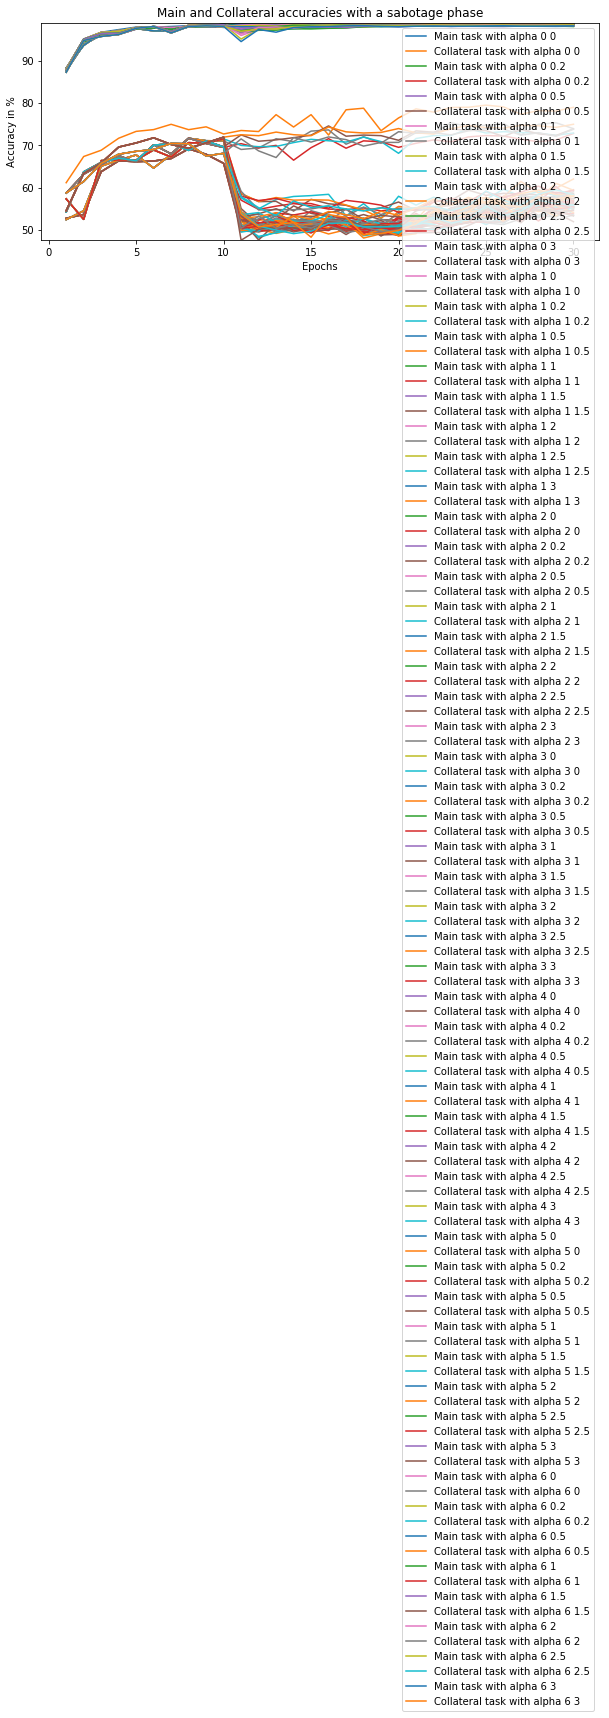

In [10]:
show_results(results, title="Main and Collateral accuracies with a sabotage phase")

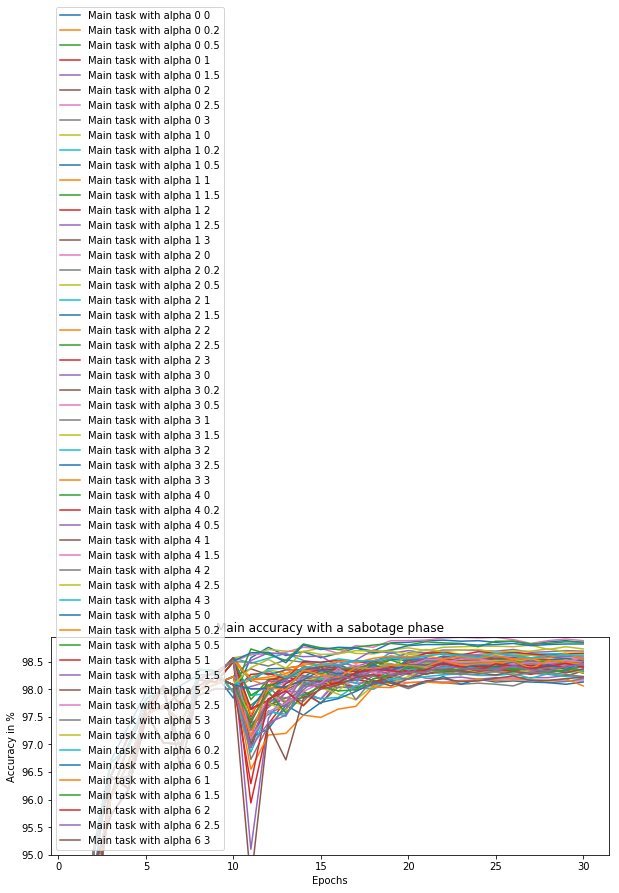

In [11]:
main_results = {k:v for k, v in results.items() if 'Main' in k}
show_results(main_results, title="Main accuracy with a sabotage phase", ymin=95)

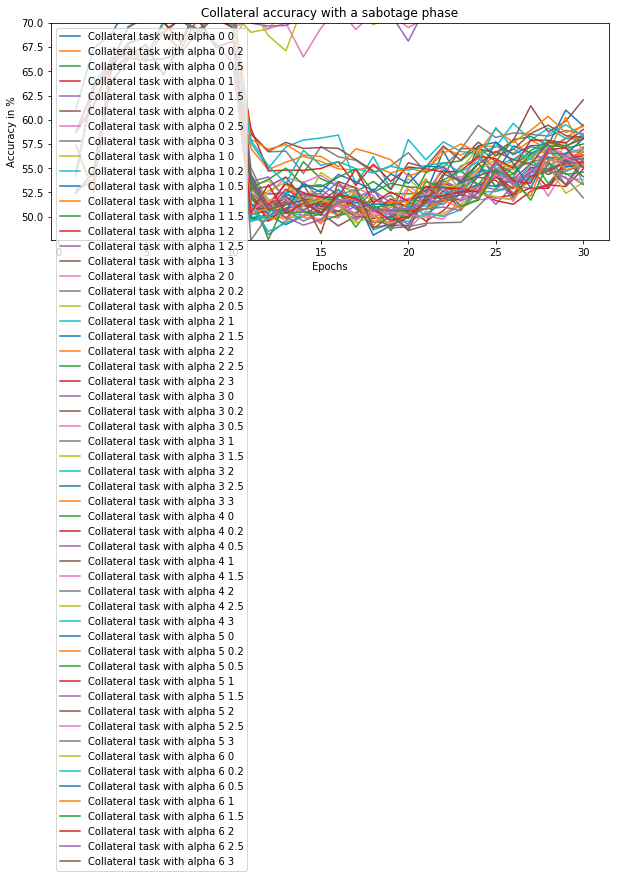

In [12]:
collateral_results = {k:v for k, v in results.items() if 'Collateral' in k}
show_results(collateral_results, title="Collateral accuracy with a sabotage phase", ymax=70)

## 5.2 Comparison of the $\alpha$ values

We report the results for a better visualisation of the trade-off that we have now:

In [16]:
import numpy as np

In [30]:
a_main_results = {}
a_collateral_results = {}
for title, res in main_results.items():
    alpha = float(title.split(' ')[-1])      
    if alpha not in a_main_results.keys():
        a_main_results[alpha] = []
    a_main_results[alpha].append(res)

for title, res in collateral_results.items():
    alpha = float(title.split(' ')[-1])   
    if alpha not in a_collateral_results.keys():
        a_collateral_results[alpha] = []
    a_collateral_results[alpha].append(res)

y_m = []
y_m_mean = []
y_m_std = []
y_c = []
y_c_mean = []
y_c_std = []
for alpha in alphas:
    output_size_main_results = [np.mean(res[-4:]) for res in a_main_results[alpha]]
    y_m_mean.append(
        np.mean(output_size_main_results)
    )
    y_m_std.append(
        np.std(output_size_main_results)
    )
    y_m.append([e for e in output_size_main_results])
    
    output_size_coll_results = [np.mean(res[-4:]) for res in a_collateral_results[alpha]]
    y_c_mean.append(
        np.mean(output_size_coll_results)
    )
    y_c_std.append(
        np.std(output_size_coll_results)
    )
    y_c.append([e for e in output_size_coll_results])
    


In [28]:
alphas

[0, 0.2, 0.5, 1, 1.5, 2, 2.5, 3]

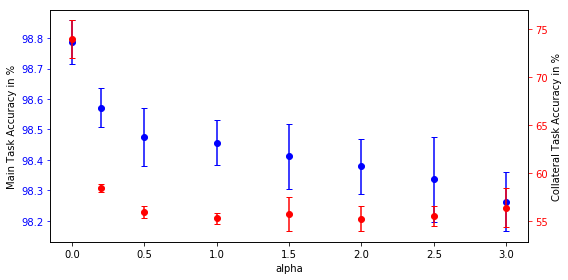

In [43]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['errorbar.capsize'] = 3

fig, ax1 = plt.subplots(figsize=(8, 4))

ax1.errorbar(alphas, y_m_mean, y_m_std, linestyle='None', marker='o', color='blue', label='Main Task accuracy')
ax1.set_xlabel('alpha')
ax1.set_ylabel('Main Task Accuracy in %')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.errorbar(alphas, y_c_mean, y_c_std, linestyle='None', marker='o', color='red', label='Collateral Task accuracy')
ax2.set_ylabel('Collateral Task Accuracy in %')
ax2.tick_params('y', colors='r')

# plt.title('Trade-off between the main and collateral tasks accuracies as a function of alpha')
fig.tight_layout()
plt.show()

^^^ This was my fancy figure :)